In [1]:
# At the very top of your script, before any imports
import os

# Clear out any existing cache variables that might cause conflicts
if "TRANSFORMERS_CACHE" in os.environ:
    print(f"Removing existing TRANSFORMERS_CACHE: {os.environ['TRANSFORMERS_CACHE']}")
    del os.environ["TRANSFORMERS_CACHE"]

# Set up environment variables and cache directories
os.environ["HF_HOME"] = os.path.join(os.getcwd(), ".hf_cache")
print(f"HF_HOME: {os.getenv('HF_HOME')}")

Removing existing TRANSFORMERS_CACHE: /storage/coda1/p-dsgt_clef2025/0/kthakrar3/hf_cache
HF_HOME: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/.hf_cache


In [2]:
# Standard library imports
import sys
import gc
import re
import ast
import json
import shutil
import random
import pickle
import datetime
import traceback
import glob
from collections import Counter, defaultdict
from pprint import pprint

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

# Machine learning and deep learning
import torch
from torch.utils.data import DataLoader
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig, MllamaForConditionalGeneration, AutoModelForVision2Seq, Qwen2VLForConditionalGeneration, Qwen2_5_VLForConditionalGeneration, AutoTokenizer

from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer

# TensorBoard related
from tensorboard.backend.event_processing import event_accumulator

# Others
from dotenv import load_dotenv
import zipfile
import requests

from qwen_vl_utils import process_vision_info

In [3]:
# Display environment information
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

# Clean memory
gc.collect()
torch.cuda.empty_cache()

Python version: 3.10.10 (main, Apr 15 2024, 11:52:16) [GCC 11.4.1 20230605 (Red Hat 11.4.1-2)]
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA A100 80GB PCIe


In [4]:
# Load environment variables, i.e. Hugging Face token
load_dotenv()

# Model configuration section
AVAILABLE_MODELS = {
    "llama-3.2-11b-vision": "meta-llama/Llama-3.2-11B-Vision-Instruct",
    "gemma-3-4b-it": "google/gemma-3-4b-it",
    "gemma-3-12b-it": "google/gemma-3-12b-it",
    "Qwen2-VL-2B-Instruct": "Qwen/Qwen2-VL-2B-Instruct",
    "Qwen2-VL-7B-Instruct": "Qwen/Qwen2-VL-7B-Instruct",
    "Qwen2.5-VL-3B-Instruct": "Qwen/Qwen2.5-VL-3B-Instruct",
    "Qwen2.5-VL-7B-Instruct": "Qwen/Qwen2.5-VL-7B-Instruct"
}

# Set the model to use - you can change this to select different models
SELECTED_MODEL = "Qwen2-VL-2B-Instruct"

# Set up paths
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATASET_DIR = os.path.join(BASE_DIR, "2025_dataset")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TRAIN_IMAGES_DIR = os.path.join(TRAIN_DIR, "images_train")
VAL_IMAGES_DIR = os.path.join(VAL_DIR, "images_valid")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)
PROCESSED_TRAIN_DATA_DIR = os.path.join(OUTPUT_DIR, "processed_train_data-TEST")
PROCESSED_VAL_DATA_DIR = os.path.join(OUTPUT_DIR, "processed_val_data-TEST")
PROCESSED_COMBINED_DATA_DIR = os.path.join(OUTPUT_DIR, "processed_combined_data-TEST")
QUESTIONS_PATH = os.path.join(TRAIN_DIR, "closedquestions_definitions_imageclef2025.json")
TRAIN_JSON_PATH = os.path.join(TRAIN_DIR, "train.json")
TRAIN_CVQA_PATH = os.path.join(TRAIN_DIR, "train_cvqa.json")
VAL_JSON_PATH = os.path.join(VAL_DIR, "valid.json")
VAL_CVQA_PATH = os.path.join(VAL_DIR, "valid_cvqa.json")

# Model configuration
MODEL_ID = AVAILABLE_MODELS[SELECTED_MODEL]
MODEL_NAME = MODEL_ID.split('/')[-1]  # Gets the model name from the path
IS_LLAMA = "llama" in MODEL_ID.lower()
IS_QWEN = "qwen" in MODEL_ID.lower()

HF_TOKEN = os.getenv("HF_TOKEN")

# Timestamp for model directory
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M")
MODEL_SAVE_DIRECTORY = os.path.join(OUTPUT_DIR, "finetuned-model", f"{MODEL_NAME}_{TIMESTAMP}")
os.makedirs(MODEL_SAVE_DIRECTORY, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Selected model: {SELECTED_MODEL}")
print(f"Model ID: {MODEL_ID}")
print(f"Is Llama model: {IS_LLAMA}")
print(f"Is Qwen model: {IS_QWEN}")
print(f"Model output directory: {MODEL_SAVE_DIRECTORY}")

Base directory: /storage/scratch1/2/kthakrar3/mediqa-magic-v2
Selected model: Qwen2-VL-2B-Instruct
Model ID: Qwen/Qwen2-VL-2B-Instruct
Is Llama model: False
Is Qwen model: True
Model output directory: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/finetuned-model/Qwen2-VL-2B-Instruct_20250427_1809


In [80]:
# First part - Before training
class Args:
    def __init__(self, use_finetuning=True):
        """
        Initialize basic inference arguments before training
        """
        self.test = True
        self.skip_data_prep = False
        self.batch_size = 100
        self.max_samples = None
        self.use_finetuning = use_finetuning
        self.use_combined_dataset = False
        self.min_data_size = 10
        # No model path or adapter path set here
        
# Create initial instance
args = Args()

In [6]:
def prepare_dataset(mode="train"):
    """
    Create a dataset for either training or validation data.
    
    Args:
        mode: Either "train" or "val" to specify which dataset to prepare
    
    Returns:
        DataFrame containing the processed dataset
    """
    print(f"Preparing {mode} dataset...")
    
    # Set the appropriate paths and directories based on mode
    if mode == "train":
        json_path = TRAIN_JSON_PATH
        cvqa_path = TRAIN_CVQA_PATH
        images_dir = TRAIN_IMAGES_DIR
        output_filename = "train_dataset_processed.csv"
    elif mode == "val":
        json_path = VAL_JSON_PATH
        cvqa_path = VAL_CVQA_PATH
        images_dir = VAL_IMAGES_DIR
        output_filename = "val_dataset.csv"
    else:
        raise ValueError("Mode must be either 'train' or 'val'")
    
    # Load question definitions
    with open(QUESTIONS_PATH, 'r') as f:
        questions = json.load(f)
        
    # Convert to DataFrame for easier manipulation
    questions_df = pd.json_normalize(questions)[["qid", "question_en", "options_en", "question_type_en", "question_category_en"]]
    
    # Load data with query information
    input_df = pd.read_json(json_path)
    
    # Extract relevant columns including query content and title
    query_info_df = input_df[["encounter_id", "image_ids", "query_title_en", "query_content_en", "author_id"]]
    
    # Load CVQA data (ground truth answers)
    with open(cvqa_path, 'r') as f:
        cvqa_data = json.load(f)
    cvqa_df = pd.json_normalize(cvqa_data)
    
    # Melt to get one row per question
    cvqa_long = cvqa_df.melt(id_vars=["encounter_id"], 
                             var_name="qid", 
                             value_name="answer_index")
    
    # Filter out encounter_id rows
    cvqa_long = cvqa_long[cvqa_long["qid"] != "encounter_id"]
    
    # Merge CVQA with questions
    cvqa_merged = cvqa_long.merge(questions_df, on="qid", how="left")
    
    # Get answer text
    def get_answer_text(row):
        try:
            return row["options_en"][row["answer_index"]]
        except (IndexError, TypeError):
            return None
    
    cvqa_merged["answer_text"] = cvqa_merged.apply(get_answer_text, axis=1)
    
    # Merge with data
    final_df = cvqa_merged.merge(query_info_df, on="encounter_id", how="left")
    
    # Extract the base CQID code
    final_df['base_qid'] = final_df['qid'].str.extract(r'(CQID\d+)')
    
    # Group by encounter_id and base_qid to see all answers for each question family
    grouped_by_family = final_df.groupby(['encounter_id', 'base_qid']).agg({
        'qid': list,
        'question_en': list,
        'answer_text': list,
        'answer_index': list,
        'image_ids': 'first',
        'options_en': 'first',
        'question_type_en': 'first',
        'question_category_en': 'first',
        'query_title_en': 'first',
        'query_content_en': 'first',
        'author_id': 'first'
    })
    
    # Reset index for easier manipulation
    grouped_by_family = grouped_by_family.reset_index()
    
    def get_valid_answers(row):
        """
        Extract all valid answers, with special handling for "Not mentioned".
        If "Not mentioned" is the only answer for all slots, we keep it.
        Otherwise, we collect all non-"Not mentioned" answers.
        """
        answers = row['answer_text']
        answer_indices = row['answer_index']

        if all(ans == "Not mentioned" for ans in answers):
            return ["Not mentioned"], [answer_indices[0]]  # If all are "Not mentioned", return it as valid

        valid_answers = []
        valid_indices = []

        for i, ans in enumerate(answers):
            if ans != "Not mentioned":
                # Clean the answer string by removing quotes and extra whitespace
                if isinstance(ans, str):
                    cleaned_ans = ans.strip("'\" ").replace(" (please specify)", "")
                    # Only add if not already in valid_answers (after cleaning)
                    if cleaned_ans not in valid_answers:
                        valid_answers.append(cleaned_ans)
                        valid_indices.append(answer_indices[i])
                else:
                    # Handle non-string answers
                    str_ans = str(ans).strip("'\" ")
                    if str_ans not in valid_answers:
                        valid_answers.append(str_ans)
                        valid_indices.append(answer_indices[i])

        return valid_answers, valid_indices
    
    # Apply to all question families
    grouped_by_family[['valid_answers', 'valid_indices']] = grouped_by_family.apply(
        lambda row: pd.Series(get_valid_answers(row)), axis=1)
    
    # Create the multi-label dataset
    dataset_rows = []
    
    # Process all encounters
    for _, row in tqdm(grouped_by_family.iterrows(), desc=f"Creating {mode} dataset"):
        encounter_id = row['encounter_id']
        base_qid = row['base_qid']
        valid_answers = row['valid_answers']
        valid_indices = row['valid_indices']
        image_ids = row['image_ids']
        question_text = row['question_en'][0]  # Taking the first question as reference
        query_title = row['query_title_en']
        query_content = row['query_content_en']
        author_id = row['author_id']
        options_en = row['options_en']
        question_type_en = row['question_type_en']
        question_category_en = row['question_category_en']
        
        # For each image in the encounter
        for img_id in image_ids:
            img_path = os.path.join(images_dir, img_id)
            
            # Skip if image doesn't exist
            if not os.path.exists(img_path):
                print(f"Warning: Image {img_id} not found at {img_path}")
                continue
                
            dataset_rows.append({
                'encounter_id': encounter_id,
                'base_qid': base_qid,
                'image_id': img_id,
                'image_path': img_path,
                'valid_answers': valid_answers,
                'valid_indices': valid_indices,
                'question_text': question_text,
                'query_title_en': query_title,
                'query_content_en': query_content,
                'author_id': author_id,
                'options_en': options_en,
                'question_type_en': question_type_en, 
                'question_category_en': question_category_en,
                'is_multi_label': len(valid_answers) > 1
            })
    
    # Convert to DataFrame
    dataset = pd.DataFrame(dataset_rows)
    
    # Save the dataset
    dataset.to_csv(os.path.join(OUTPUT_DIR, output_filename), index=False)
    
    print(f"{mode.capitalize()} dataset created with {len(dataset)} entries")
    
    return dataset

In [7]:
def prepare_and_process_datasets(args):
    """
    Prepare and process datasets based on arguments.
    
    Args:
        args: Arguments containing test, skip_data_prep, and other parameters
        
    Returns:
        Tuple containing (train_df, val_df)
    """
    # Initialize return variables
    train_df = None
    val_df = None
    
    # Skip data preparation if requested
    if args.skip_data_prep:
        print("Skipping data preparation...")
        
        # load existing data
        if os.path.exists(os.path.join(OUTPUT_DIR, "train_dataset_processed.csv")):
            train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_dataset_processed.csv"))
            print(f"Loaded existing training dataset with {len(train_df)} samples")
        
        if os.path.exists(os.path.join(OUTPUT_DIR, "val_dataset.csv")):
            val_df = pd.read_csv(os.path.join(OUTPUT_DIR, "val_dataset.csv"))
            print(f"Loaded existing validation dataset with {len(val_df)} samples")

    else:
        
        # Create combined dataset if requested
        if args.use_combined_dataset:
            print("Creating combined train+val dataset...")

            # Prepare training dataset
            print("Preparing training dataset...")
            train_df = prepare_dataset(mode="train")
            
            # Prepare validation dataset
            print("Preparing validation dataset...")
            val_df = prepare_dataset(mode="val")
        
            # Combine datasets
            train_df = pd.concat([train_df, val_df], ignore_index=True)
            val_df = None
            
            # Save the combined dataset
            combined_file = os.path.join(OUTPUT_DIR, "combined_train_val_dataset.csv")
            train_df.to_csv(combined_file, index=False)
            print(f"Combined dataset saved to {combined_file} with {len(train_df)} samples")
                        
        else: 
            
            # Prepare training dataset
            print("Preparing training dataset...")
            train_df = prepare_dataset(mode="train")
            
            # Prepare validation dataset
            print("Preparing validation dataset...")
            val_df = prepare_dataset(mode="val")
            
        
        # Apply test restriction if needed
        if args.test:
            print("Running in test mode with a small subset of data...")
            
            if train_df is not None:
                test_size = min(args.min_data_size, len(train_df))
                train_df = train_df.head(test_size)
                print(f"Using {len(train_df)} training samples for testing")
            
            if val_df is not None:
                test_size = min(args.min_data_size, len(val_df))
                val_df = val_df.head(test_size)
                print(f"Using {len(val_df)} validation samples for testing")
        
        # Set up and clean directories
        if args.use_combined_dataset:
            # Clear combined directory
            if os.path.exists(PROCESSED_COMBINED_DATA_DIR):
                shutil.rmtree(PROCESSED_COMBINED_DATA_DIR)
            os.makedirs(PROCESSED_COMBINED_DATA_DIR, exist_ok=True)
        else:
            # Clear training directory
            if os.path.exists(PROCESSED_TRAIN_DATA_DIR):
                shutil.rmtree(PROCESSED_TRAIN_DATA_DIR)
            os.makedirs(PROCESSED_TRAIN_DATA_DIR, exist_ok=True)
        
            # Clear validation directory
            if os.path.exists(PROCESSED_VAL_DATA_DIR):
                shutil.rmtree(PROCESSED_VAL_DATA_DIR)
            os.makedirs(PROCESSED_VAL_DATA_DIR, exist_ok=True)
    
    # Return datasets
    return train_df, val_df

In [8]:
train_df, val_df = prepare_and_process_datasets(args)

Preparing training dataset...
Preparing train dataset...


Creating train dataset: 0it [00:00, ?it/s]

Train dataset created with 7893 entries
Preparing validation dataset...
Preparing val dataset...


Creating val dataset: 0it [00:00, ?it/s]

Val dataset created with 1413 entries
Running in test mode with a small subset of data...
Using 10 training samples for testing
Using 10 validation samples for testing


In [9]:
train_df.columns

Index(['encounter_id', 'base_qid', 'image_id', 'image_path', 'valid_answers',
       'valid_indices', 'question_text', 'query_title_en', 'query_content_en',
       'author_id', 'options_en', 'question_type_en', 'question_category_en',
       'is_multi_label'],
      dtype='object')

In [10]:
train_df.head()

,encounter_id,base_qid,image_id,image_path,valid_answers,valid_indices,question_text,query_title_en,query_content_en,author_id,options_en,question_type_en,question_category_en,is_multi_label
0,ENC00001,CQID010,IMG_ENC00001_00001.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[limited area],[1],How much of the body is affected?,Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,U04473,"[single spot, limited area, widespread, Not me...",Site,General,False
1,ENC00001,CQID010,IMG_ENC00001_00002.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[limited area],[1],How much of the body is affected?,Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,U04473,"[single spot, limited area, widespread, Not me...",Site,General,False
2,ENC00001,CQID011,IMG_ENC00001_00001.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[back],[5],1 Where is the affected area?,Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,U04473,"[head, neck, upper extremities, lower extremit...",Site Location,General,False
3,ENC00001,CQID011,IMG_ENC00001_00002.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[back],[5],1 Where is the affected area?,Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,U04473,"[head, neck, upper extremities, lower extremit...",Site Location,General,False
4,ENC00001,CQID012,IMG_ENC00001_00001.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[size of palm],[1],1 How large are the affected areas? Please spe...,Pleural effusion accompanied by rash,A patient with pleural effusion is accompanied...,U04473,"[size of thumb nail, size of palm, larger area...",Size,General,False


In [11]:
val_df.head()

,encounter_id,base_qid,image_id,image_path,valid_answers,valid_indices,question_text,query_title_en,query_content_en,author_id,options_en,question_type_en,question_category_en,is_multi_label
0,ENC00852,CQID010,IMG_ENC00852_00001.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[limited area],[1],How much of the body is affected?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[single spot, limited area, widespread, Not me...",Site,General,False
1,ENC00852,CQID010,IMG_ENC00852_00002.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[limited area],[1],How much of the body is affected?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[single spot, limited area, widespread, Not me...",Site,General,False
2,ENC00852,CQID011,IMG_ENC00852_00001.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,"[upper extremities, head]","[2, 0]",1 Where is the affected area?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[head, neck, upper extremities, lower extremit...",Site Location,General,True
3,ENC00852,CQID011,IMG_ENC00852_00002.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,"[upper extremities, head]","[2, 0]",1 Where is the affected area?,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[head, neck, upper extremities, lower extremit...",Site Location,General,True
4,ENC00852,CQID012,IMG_ENC00852_00001.jpg,/storage/scratch1/2/kthakrar3/mediqa-magic-v2/...,[size of palm],[1],1 How large are the affected areas? Please spe...,Is this Vitiligo? Please see picture.,"The patient is a middle age female, about 50 y...",U00295,"[size of thumb nail, size of palm, larger area...",Size,General,False


In [12]:
def safe_convert_options(options_str):
    """
    Safely convert a string representation of a list to an actual list.
    """
    if not isinstance(options_str, str):
        return options_str
        
    try:
        # Use ast.literal_eval which is safer than eval()
        return ast.literal_eval(options_str)
    except (SyntaxError, ValueError):
        # Try common formats
        if options_str.startswith('[') and options_str.endswith(']'):
            # Strip brackets and split by commas
            return [opt.strip().strip("'\"") for opt in options_str[1:-1].split(',')]
        elif ',' in options_str:
            # Just split by commas
            return [opt.strip() for opt in options_str.split(',')]
        else:
            # Single option
            return [options_str]

In [13]:
def process_dataset_batch(batch_df, batch_idx, save_dir, images_dir, mode="train"):
    """
    Process a batch of data samples and save them as a pickle file.
    Works for both training and validation/inference datasets.
    
    Args:
        batch_df: DataFrame containing the batch to process
        batch_idx: Index of the batch (for naming the output file)
        save_dir: Directory to save the processed batch
        images_dir: Directory containing the images
        mode: Either "train" or "val"/"inference" to determine processing
    
    Returns:
        Number of successfully processed examples
    """
    os.makedirs(save_dir, exist_ok=True)
    batch_data = []
    
    # Determine file prefix based on mode
    file_prefix = "batch_" if mode == "train" else "val_batch_"
    
    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx}"):
        try:
            # Get image path
            image_id = row.get('image_id')
            if not image_id:
                continue
                
            # Use the full image path if it's already in the dataframe and exists
            if 'image_path' in row and os.path.exists(row['image_path']):
                image_path = row['image_path']
            else:
                # Otherwise construct from images_dir and image_id
                image_path = os.path.join(images_dir, image_id)
            
            # Skip if image doesn't exist
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            # Verify the image is valid
            try:
                with Image.open(image_path) as img:
                    img.load()
            except Exception as e:
                print(f"Corrupt or unreadable image at {image_path} — {e}")
                continue
            
            # Get options from options_en
            if 'options_en' in row:
                options = safe_convert_options(row['options_en'])
                
                # Clean up options by removing "(please specify)" phrases
                cleaned_options = []
                for opt in options:
                    if isinstance(opt, str):
                        # Remove "(please specify)" from option text
                        cleaned_opt = opt.strip("'\" ").replace(" (please specify)", "")
                        cleaned_options.append(cleaned_opt)
                    else:
                        cleaned_options.append(str(opt).strip("'\" "))
                options = cleaned_options
            else:
                options = ["Yes", "No", "Not mentioned"]
                
            options_text = ", ".join(options)
            
            # Create metadata string
            metadata = ""
            if 'question_type_en' in row:
                metadata += f"Type: {row['question_type_en']}"
                
            if 'question_category_en' in row:
                metadata += f", Category: {row['question_category_en']}"
            
            # Get question text and clean it
            question = row.get('question_text', 'What do you see in this image?')
            
            # Remove "Please specify which affected area for each selection." from CQID012
            if "Please specify which affected area for each selection" in question:
                question = question.replace(" Please specify which affected area for each selection.", "")
            
            # Remove leading numbers like "1 " from the beginning of questions
            question = re.sub(r'^\d+\s+', '', question)
            
            # Get clinical context from query title and content
            query_title = row.get('query_title_en', '')
            query_content = row.get('query_content_en', '')
            
            # Create the clinical context section
            clinical_context = ""
            if query_title or query_content:
                clinical_context += "Background Clinical Information (to help with your analysis):\n"
                if query_title:
                    clinical_context += f"{query_title}\n"
                if query_content:
                    clinical_context += f"{query_content}\n"

            # Create the full query text with clinical context
            query_text = (f"MAIN QUESTION TO ANSWER: {question}\n"
                         f"Question Metadata: {metadata}\n"
                         f"{clinical_context}"
                         f"Available Options (choose from these): {options_text}")
            
            # Create the data item with common fields
            data_item = {
                "id": row.get('encounter_id', str(idx)),
                "qid": row.get('base_qid', ''),
                "query_text": query_text,
                "image_path": image_path,
                "question_type": row.get('question_type_en', ''),
                "question_category": row.get('question_category_en', '')
            }
            
            # For training mode, add the answer text
            if mode == "train":
                # Get answer text - from valid_answers and clean it
                if 'valid_answers' in row and row['valid_answers']:
                    # For multi-label, join all valid answers
                    answers = row['valid_answers']
                    if isinstance(answers, list):
                        # Clean the answers by removing "(please specify)"
                        cleaned_answers = []
                        for ans in answers:
                            if isinstance(ans, str):
                                # Remove any quotes and trailing/leading spaces
                                cleaned_ans = ans.strip("'\" ")
                                # Remove "(please specify)"
                                cleaned_ans = cleaned_ans.replace(" (please specify)", "")
                                cleaned_answers.append(cleaned_ans)
                            else:
                                cleaned_answers.append(str(ans).strip("'\" "))
                        
                        if len(cleaned_answers) > 1:
                            # Join multiple answers with commas
                            answer_text = ", ".join(cleaned_answers)
                        elif len(cleaned_answers) == 1:
                            answer_text = cleaned_answers[0]
                        else:
                            answer_text = "Not mentioned"
                    else:
                        # Clean single answer
                        if isinstance(answers, str):
                            # Remove any quotes and leading/trailing spaces
                            answer_text = answers.strip("'\" ")
                            answer_text = answer_text.replace(" (please specify)", "")
                        else:
                            answer_text = str(answers).strip("'\" ")
                            
                    # Make sure the answer is stored as plain text, not as a string representation of a list
                    if isinstance(answer_text, str) and answer_text.startswith("[") and answer_text.endswith("]"):
                        # Extract content from list representation
                        clean_text = answer_text.strip("[]'")
                        # Split by quoted separators and rejoin with clean commas
                        parts = [part.strip() for part in clean_text.split("', '")]
                        answer_text = ", ".join(parts)
                
                elif 'multi_label' in row:
                    answer_text = row['multi_label']
                else:
                    answer_text = "Not mentioned"
                
                data_item["answer_text"] = answer_text
            
            batch_data.append(data_item)
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            traceback.print_exc()
    
    # Save the batch with appropriate prefix
    batch_file = os.path.join(save_dir, f"{file_prefix}{batch_idx}.pkl")
    with open(batch_file, 'wb') as f:
        pickle.dump(batch_data, f)
    
    return len(batch_data)

def preprocess_dataset(df, batch_size=50, save_dir=None, images_dir=None, mode="train", args=None):
    """
    Process an entire dataset in batches.
    Works for both training and validation/inference datasets.
    
    Args:
        df: DataFrame containing the dataset
        batch_size: Number of examples per batch
        save_dir: Directory to save processed batches
        images_dir: Directory containing images
        mode: Either "train" or "val"/"inference"
        args: Arguments containing use_combined_dataset flag
        
    Returns:
        Total number of processed examples
    """
    total_processed = 0
    
    # Select appropriate directories based on mode and args
    if save_dir is None:
        if mode == "train" and args is not None and args.use_combined_dataset:
            save_dir = PROCESSED_COMBINED_DATA_DIR
        elif mode == "train":
            save_dir = PROCESSED_TRAIN_DATA_DIR
        else:
            save_dir = PROCESSED_VAL_DATA_DIR
    
    if images_dir is None:
        images_dir = TRAIN_IMAGES_DIR if mode == "train" else VAL_IMAGES_DIR
    
    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_idx = i // batch_size
        
        print(f"Processing batch {batch_idx+1}/{(len(df)-1)//batch_size + 1}")
        processed = process_dataset_batch(batch_df, batch_idx, save_dir, images_dir, mode=mode)
        total_processed += processed
        
        gc.collect()
        
        print(f"Processed {total_processed} examples so far")
    
    return total_processed

In [14]:
if not args.skip_data_prep:
    total_examples = preprocess_dataset(train_df, batch_size=100, mode="train", args=args)
    print(f"Total processed examples: {total_examples}")
else:
    print("Skipping data preparation...")

Processing batch 1/1


Batch 0:   0%|          | 0/10 [00:00<?, ?it/s]

Processed 10 examples so far
Total processed examples: 10


In [15]:
# Check the processed data
def check_processed_sample(args):
    """
    Check a sample of processed data and display it
    """
    # Determine which directory to check based on args
    if args.use_combined_dataset:
        check_dir = PROCESSED_COMBINED_DATA_DIR
    else:
        check_dir = PROCESSED_TRAIN_DATA_DIR
    
    batch_file = os.path.join(check_dir, "batch_0.pkl")
    
    try:
        with open(batch_file, 'rb') as f:
            batch_data = pickle.load(f)
        
        print(f"\nSample of processed data from {check_dir}:")
        
        # Check first example
        print("\nFirst example:")
        sample_data = batch_data[0]
        for key, value in sample_data.items():
            print(f"{key}: {value}")
        
        # Check second example
        print("\nSecond example:")
        sample_data = batch_data[1]
        for key, value in sample_data.items():
            print(f"{key}: {value}")
            
        return True
    except Exception as e:
        print(f"Error checking processed data: {e}")
        return False

In [16]:
check_processed_sample(args)


Sample of processed data from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/processed_train_data-TEST:

First example:
id: ENC00001
qid: CQID010
query_text: MAIN QUESTION TO ANSWER: How much of the body is affected?
Question Metadata: Type: Site, Category: General
Background Clinical Information (to help with your analysis):
Pleural effusion accompanied by rash
A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the back picture is available).
Available Options (choose from these): single spot, limited area, widespread, Not mentioned
image_path: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/2025_dataset/train/images_train/IMG_ENC00001_00001.jpg
question_type: Site
question_category: General
answer_text: limited area

Second example:
id: ENC00001
qid: CQID010
query_text: MAIN QUESTION TO ANSWER: How much of the body is affected?
Question Metadata: Type: Site, Category: General
Background Clinical Information (to help with yo

True

In [17]:
def inspect_llm_training_inputs(processed_dir=None, args=None, qids=["CQID034", "CQID012", "CQID011"], 
                               multi_label_examples=True, single_label_examples=True, 
                               num_samples_per_qid=1, show_images=True):
    """
    Shows the exact inputs that would be sent to the LLM during training.
    
    Args:
        processed_dir: Directory containing processed batch files
        args: Arguments containing use_combined_dataset flag
        qids: List of QIDs to look for
        multi_label_examples: Whether to include multi-label examples
        single_label_examples: Whether to include single-label examples
        num_samples_per_qid: How many samples to show for each QID
        show_images: Whether to display the images
    """
    # Determine the correct directory to use
    if processed_dir is None:
        if args is not None and args.use_combined_dataset:
            processed_dir = PROCESSED_COMBINED_DATA_DIR
        else:
            processed_dir = PROCESSED_TRAIN_DATA_DIR
    
    print(f"Inspecting LLM training inputs from: {processed_dir}")
    
    # Rest of the function remains the same...
    # Look in multiple batch files
    batch_files = sorted([f for f in os.listdir(processed_dir) 
                          if f.startswith("batch_") and f.endswith(".pkl")])
    
    # Dictionary to store examples by QID and label type
    examples_by_qid = defaultdict(lambda: {"multi": [], "single": []})
    
    # Scan batch files to find examples
    for batch_file in batch_files:
        file_path = os.path.join(processed_dir, batch_file)
        try:
            with open(file_path, 'rb') as f:
                batch_data = pickle.load(f)
            
            # Filter by requested QIDs
            for sample in batch_data:
                sample_qid = sample['qid']
                if any(sample_qid.startswith(qid) for qid in qids):
                    # Check if it's multi-label
                    is_multi_label = ',' in sample['answer_text']
                    
                    # Store in appropriate category
                    if is_multi_label and multi_label_examples:
                        examples_by_qid[sample_qid]["multi"].append(sample)
                    elif not is_multi_label and single_label_examples:
                        examples_by_qid[sample_qid]["single"].append(sample)
            
            # Check if we've found enough examples for each QID
            all_found = True
            for qid in qids:
                qid_examples = [key for key in examples_by_qid.keys() if key.startswith(qid)]
                if not qid_examples:
                    all_found = False
                    break
                    
                for q in qid_examples:
                    if multi_label_examples and len(examples_by_qid[q]["multi"]) < num_samples_per_qid:
                        if not examples_by_qid[q]["multi"]:  # Only if we have no examples yet
                            all_found = False
                    if single_label_examples and len(examples_by_qid[q]["single"]) < num_samples_per_qid:
                        if not examples_by_qid[q]["single"]:  # Only if we have no examples yet
                            all_found = False
            
            if all_found:
                break
                
        except Exception as e:
            print(f"Error processing {batch_file}: {e}")
    
    # Display the examples
    sample_count = 0
    
    for qid in qids:
        matching_qids = [key for key in examples_by_qid.keys() if key.startswith(qid)]
        
        if not matching_qids:
            print(f"\nNo examples found for QID {qid}")
            continue
            
        for matching_qid in matching_qids:
            # Display multi-label examples
            if multi_label_examples and examples_by_qid[matching_qid]["multi"]:
                examples = examples_by_qid[matching_qid]["multi"][:num_samples_per_qid]
                for i, sample in enumerate(examples):
                    sample_count += 1
                    display_llm_training_input(sample, sample_count, show_images)
            
            # Display single-label examples
            if single_label_examples and examples_by_qid[matching_qid]["single"]:
                examples = examples_by_qid[matching_qid]["single"][:num_samples_per_qid]
                for i, sample in enumerate(examples):
                    sample_count += 1
                    display_llm_training_input(sample, sample_count, show_images)
    
    if sample_count == 0:
        print("No matching examples found. Try different QIDs or check your data directory.")

def display_llm_training_input(sample, sample_num, show_images=True):
    """
    Display a single example formatted exactly as it would be sent to the LLM.
    """
    
    print(f"\n{'='*100}")
    print(f"EXAMPLE #{sample_num}: {sample['qid']}")
    print(f"{'='*100}")
    
    # Basic info
    print(f"ID: {sample['id']}")
    print(f"Question ID: {sample['qid']}")
    print(f"Type: {sample['question_type']}")
    print(f"Category: {sample['question_category']}")
    print(f"Image path: {sample['image_path']}")
    
    # Determine if multi-label
    is_multi_label = ',' in sample['answer_text']
    print(f"Multi-label: {is_multi_label}")
    
    # Show the image if requested
    if show_images and os.path.exists(sample['image_path']):
        try:
            img = Image.open(sample['image_path'])
            width, height = img.size
            print(f"Image dimensions: {width}x{height}")
            
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(f"Image for {os.path.basename(sample['image_path'])}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error displaying image: {e}")
    
    # Define the system message as in your MedicalImageDataset class   
    system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

    IMPORTANT: 
    - Respond ONLY with the exact text of the option(s) that apply
    - Do not provide any explanations
    - Do not include the numbers that appear before options (like '1.' or '2')
    - Do not write "Options:" or similar prefixes
    - Do not write "Answer:" or similar prefixes
    - Multiple answers should be separated by commas
    - If unsure, respond with "Not mentioned"
    - The 'Background Clinical Information' section contains context to help you answer the main question
    - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
    """
    
    # Format as would be sent to the LLM
    print("\nACTUAL LLM INPUT (as formatted in your MedicalImageDataset):")
    print("-" * 100)
    print("System message:")
    print(system_message)
    print("\nUser message:")
    print(sample['query_text'])
    print("[IMAGE WOULD BE INCLUDED HERE]")
    print("-" * 100)
    
    # Expected output
    print("\nEXPECTED LLM OUTPUT:")
    print("-" * 100)
    print(sample['answer_text'])
    print("-" * 100)
    
    # If multi-label, show split answers
    if is_multi_label:
        answers = [ans.strip() for ans in sample['answer_text'].split(",")]
#         print(f"\nSplit answers:")
#         for ans in answers:
#             print(f"- {ans}")
    
    # Show what this would look like after chat template is applied
    print("\nCHAT TEMPLATE FORMAT (approximate):")
    print("-" * 100)
    print("<bos><begin_of_system>\nYou are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. \nIMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. \n- Do not provide any explanations\n- Do not include option numbers\n- Do not write \"Options:\" or similar prefixes\n- Do not write \"Answer:\" or similar prefixes\n- Multiple answers should be separated by commas\n- If unsure, respond with \"Not mentioned\"\n<end_of_system>\n\n<begin_of_user>\n" + sample['query_text'] + "\n<boi>IMAGE_EMBEDDING_TOKENS<eoi>\n<end_of_user>\n\n<begin_of_assistant>\n" + sample['answer_text'] + "<end_of_assistant>")
    print("-" * 100)

Inspecting LLM training inputs from: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/processed_train_data-TEST

No examples found for QID CQID034

EXAMPLE #1: CQID012
ID: ENC00001
Question ID: CQID012
Type: Size
Category: General
Image path: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/2025_dataset/train/images_train/IMG_ENC00001_00001.jpg
Multi-label: False
Image dimensions: 1944x2541


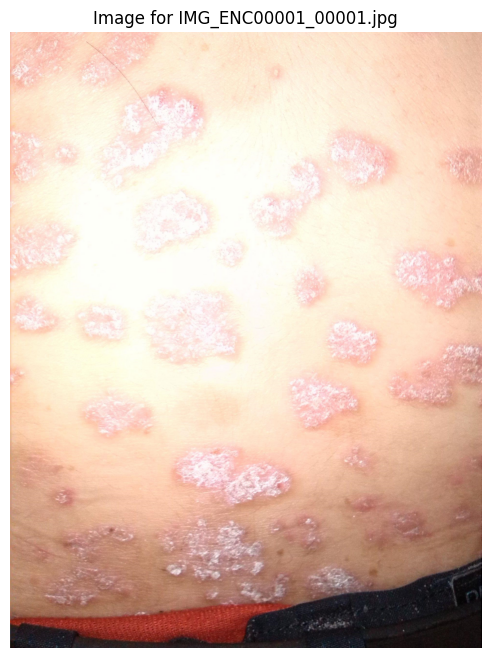


ACTUAL LLM INPUT (as formatted in your MedicalImageDataset):
----------------------------------------------------------------------------------------------------
System message:
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

    IMPORTANT: 
    - Respond ONLY with the exact text of the option(s) that apply
    - Do not provide any explanations
    - Do not include the numbers that appear before options (like '1.' or '2')
    - Do not write "Options:" or similar prefixes
    - Do not write "Answer:" or similar prefixes
    - Multiple answers should be separated by commas
    - If unsure, respond with "Not mentioned"
    - The 'Background Clinical Information' section contains context to help you answer the main question
    - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
    

User message:
MAIN QUESTION TO ANSWER: How large are the affected areas?
Question Metada

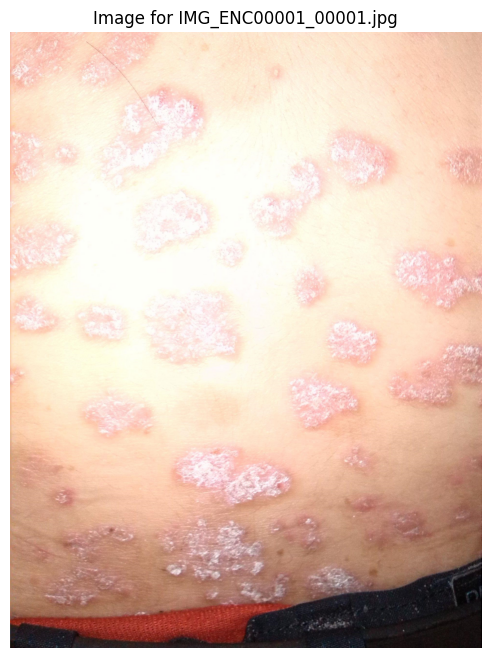


ACTUAL LLM INPUT (as formatted in your MedicalImageDataset):
----------------------------------------------------------------------------------------------------
System message:
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

    IMPORTANT: 
    - Respond ONLY with the exact text of the option(s) that apply
    - Do not provide any explanations
    - Do not include the numbers that appear before options (like '1.' or '2')
    - Do not write "Options:" or similar prefixes
    - Do not write "Answer:" or similar prefixes
    - Multiple answers should be separated by commas
    - If unsure, respond with "Not mentioned"
    - The 'Background Clinical Information' section contains context to help you answer the main question
    - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
    

User message:
MAIN QUESTION TO ANSWER: Where is the affected area?
Question Metadata: Ty

In [18]:
inspect_llm_training_inputs(
    args=args,  # Pass args to handle combined directory
    qids=["CQID034", "CQID012", "CQID011"],      
    multi_label_examples=True,                   
    single_label_examples=True,                  
    num_samples_per_qid=1,                       
    show_images=True                             
)

In [19]:
if not args.skip_data_prep:
    total_examples = preprocess_dataset(val_df, batch_size=100, mode="val")
    print(f"Total processed examples: {total_examples}")
else:
    print("Skipping data preparation...")

Processing batch 1/1


Batch 0:   0%|          | 0/10 [00:00<?, ?it/s]

Processed 10 examples so far
Total processed examples: 10


In [20]:
def inspect_inference_inputs(processed_val_dir=None, num_samples=3):
    """
    Inspect the actual inputs being used during inference by examining the
    processed validation data files.
    
    Args:
        processed_val_dir: Directory containing processed validation data
        num_samples: Number of samples to display
    """
    # Use global variable if no directory is provided
    if processed_val_dir is None:
        processed_val_dir = PROCESSED_VAL_DATA_DIR
        
    # Find all batch files
    batch_files = sorted([f for f in os.listdir(processed_val_dir) 
                         if f.startswith("val_batch_") and f.endswith(".pkl")])
    
    if not batch_files:
        print(f"No batch files found in {processed_val_dir}")
        return
    
    print(f"Found {len(batch_files)} batch files in {processed_val_dir}")
    
    # Load the first batch file
    with open(os.path.join(processed_val_dir, batch_files[0]), 'rb') as f:
        batch_data = pickle.load(f)
    
    print(f"Batch contains {len(batch_data)} samples")
    
    # Display the requested number of samples
    for i, sample in enumerate(batch_data[:num_samples]):
        print(f"\n{'='*80}")
        print(f"SAMPLE {i+1}")
        print(f"{'='*80}")
        
        # Display metadata
        print(f"ID: {sample['id']}")
        print(f"Question ID: {sample['qid']}")
        
        # Display the data that would be fed to the model
        print("\nSYSTEM MESSAGE (Used during inference):")
        print("-" * 80)
        # Create the system message
        system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.
        
        IMPORTANT: 
        - Respond ONLY with the exact text of the option(s) that apply
        - Do not provide any explanations
        - Do not include the numbers that appear before options (like '1.' or '2')
        - Do not write "Options:" or similar prefixes
        - Do not write "Answer:" or similar prefixes
        - Multiple answers should be separated by commas
        - If unsure, respond with "Not mentioned"
        - The 'Background Clinical Information' section contains context to help you answer the main question
        - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
        """
        
        print(system_message)
        print("-" * 80)
        
        # Display the query text
        print("\nUSER MESSAGE TEXT (Used during inference):")
        print("-" * 80)
        print(sample['query_text'])
        print("-" * 80)
        
        # Display image information
        print("\nIMAGE (Used during inference):")
        print(f"Image path: {sample['image_path']}")
        
        # Try to display image dimensions if PIL is available
        try:
            img = Image.open(sample['image_path'])
            print(f"Image dimensions: {img.size[0]}x{img.size[1]}, Format: {img.format}")
        except Exception as e:
            print(f"Could not open image: {e}")
        
        print("-" * 80)
        
        # Option to stop after showing samples
        if i >= num_samples - 1:
            break

In [21]:
# Run the inspection function
inspect_inference_inputs(num_samples=2)

Found 1 batch files in /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/processed_val_data-TEST
Batch contains 10 samples

SAMPLE 1
ID: ENC00852
Question ID: CQID010

SYSTEM MESSAGE (Used during inference):
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.
        
        IMPORTANT: 
        - Respond ONLY with the exact text of the option(s) that apply
        - Do not provide any explanations
        - Do not include the numbers that appear before options (like '1.' or '2')
        - Do not write "Options:" or similar prefixes
        - Do not write "Answer:" or similar prefixes
        - Multiple answers should be separated by commas
        - If unsure, respond with "Not mentioned"
        - The 'Background Clinical Information' section contains context to help you answer the main question
        - ONLY answer th

In [22]:
def get_model_config(torch_dtype=None):
    """Create standardized model configuration dictionary"""
    if torch_dtype is None:
        torch_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
        
    # Configure base model parameters (common to all models)
    model_kwargs = dict(
        torch_dtype=torch_dtype,
        device_map="auto" if torch.cuda.is_available() else None
    )
    
    # Configure quantization for memory efficiency
    model_kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
        bnb_4bit_quant_storage=model_kwargs["torch_dtype"]
    )
    
    return model_kwargs

# Check if GPU can support bfloat16
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] < 8:
    print("WARNING: GPU may not fully support bfloat16. Consider using float16 instead.")

# Get standardized model configuration
model_kwargs = get_model_config(torch_dtype=torch.bfloat16)

# Load the model based on model type
if IS_LLAMA:
    # Use MllamaForConditionalGeneration for Llama models
    model = MllamaForConditionalGeneration.from_pretrained(MODEL_ID, **model_kwargs)
    if hasattr(model, "tie_weights"):
        model.tie_weights()
elif IS_QWEN:
    # Use Qwen2VLForConditionalGeneration for Qwen models
    if "2.5" in MODEL_ID:
        model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_ID, **model_kwargs)
    else:
        model = Qwen2VLForConditionalGeneration.from_pretrained(MODEL_ID, **model_kwargs)
else:
    # For non-Llama, non-Qwen models, use AutoModelForImageTextToText with eager attention
    non_llama_kwargs = model_kwargs.copy()
    non_llama_kwargs["attn_implementation"] = "eager"
    model = AutoModelForImageTextToText.from_pretrained(MODEL_ID, **non_llama_kwargs)

# Load processor first to use in the dataset class
processor = AutoProcessor.from_pretrained(MODEL_ID, token=HF_TOKEN)

# Print info about the chat template
print(f"Default chat template: {processor.tokenizer.chat_template}")
print(f"Special tokens map: {processor.tokenizer.special_tokens_map}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Default chat template: {% set image_count = namespace(value=0) %}{% set video_count = namespace(value=0) %}{% for message in messages %}{% if loop.first and message['role'] != 'system' %}<|im_start|>system
You are a helpful assistant.<|im_end|>
{% endif %}<|im_start|>{{ message['role'] }}
{% if message['content'] is string %}{{ message['content'] }}<|im_end|>
{% else %}{% for content in message['content'] %}{% if content['type'] == 'image' or 'image' in content or 'image_url' in content %}{% set image_count.value = image_count.value + 1 %}{% if add_vision_id %}Picture {{ image_count.value }}: {% endif %}<|vision_start|><|image_pad|><|vision_end|>{% elif content['type'] == 'video' or 'video' in content %}{% set video_count.value = video_count.value + 1 %}{% if add_vision_id %}Video {{ video_count.value }}: {% endif %}<|vision_start|><|video_pad|><|vision_end|>{% elif 'text' in content %}{{ content['text'] }}{% endif %}{% endfor %}<|im_end|>
{% endif %}{% endfor %}{% if add_generation_pr

In [23]:
class MedicalImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, processor):
        self.processor = processor
        self.examples = []
        
        for batch_file in sorted(os.listdir(data_dir)):
            if batch_file.startswith("batch_") and batch_file.endswith(".pkl"):
                with open(os.path.join(data_dir, batch_file), 'rb') as f:
                    batch_data = pickle.load(f)
                    self.examples.extend(batch_data)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        # Open image and convert to RGB
        image = Image.open(example['image_path']).convert("RGB")
        
        # Define system message for medical image analysis
        system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

        IMPORTANT: 
        - Respond ONLY with the exact text of the option(s) that apply
        - Do not provide any explanations
        - Do not include the numbers that appear before options (like '1.' or '2')
        - Do not write "Options:" or similar prefixes
        - Do not write "Answer:" or similar prefixes
        - Multiple answers should be separated by commas
        - If unsure, respond with "Not mentioned"
        - The 'Background Clinical Information' section contains context to help you answer the main question
        - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
        """
        
        # Format as a conversation with system, user, and assistant messages
        messages = [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": example['query_text']},
                    {"type": "image", "image": image},
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": example['answer_text']}],
            },
        ]
        
        return {"messages": messages}

In [24]:
# Custom collate function with specific handling for different model types
def collate_fn(examples):
    """Custom collate function for batching examples for vision models."""
    texts = []
    images = []
    
    for example in examples:
        # Extract image from messages
        image_input = None
        for msg in example["messages"]:
            if msg["role"] == "user":
                for content in msg["content"]:
                    if isinstance(content, dict) and content.get("type") == "image" and "image" in content:
                        image_input = content["image"]
                        break
        
        if image_input is None:
            # Create a dummy image if needed
            image_input = Image.new('RGB', (224, 224), color='black')
            
        # Process the conversation using the chat template
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        
        texts.append(text.strip())
        images.append([image_input])
    
    # Process both text and images
    batch = processor(
        text=texts, 
        images=images,
        return_tensors="pt", 
        padding=True
    )
    
    # Create the labels for loss calculation
    labels = batch["input_ids"].clone()
    
    # Mask padding tokens
    if processor.tokenizer.pad_token_id is not None:
        labels[labels == processor.tokenizer.pad_token_id] = -100
    
    # Handle special tokens based on model type
    if IS_LLAMA:
        # Mask all special tokens in Llama models
        for token_id in processor.tokenizer.all_special_ids:
            labels[labels == token_id] = -100
        
        # Check if processor has image_token attribute and mask it
        try:
            if hasattr(processor, "image_token"):
                image_token_id = processor.tokenizer.convert_tokens_to_ids(processor.image_token)
                labels[labels == image_token_id] = -100
        except:
            pass
            
        # Specifically handle vision tokens for Llama
        if hasattr(processor, "image_token_index"):
            # If the processor exposes the image token directly
            labels[labels == processor.image_token_index] = -100
        else:
            # Try to find image token via known token patterns
            # Llama Vision uses special tokens for image embeddings
            image_tokens = []
            
            # Try to get image token by name - including BOS and EOS explicitly
            image_token_names = ["<boi>", "<eoi>", "<image>", "<|image|>", "bos_token", "eos_token"]
            for token_name in image_token_names:
                try:
                    token_id = processor.tokenizer.convert_tokens_to_ids(token_name)
                    if token_id != processor.tokenizer.unk_token_id:
                        image_tokens.append(token_id)
                except:
                    pass
                    
            # Mask any found image tokens
            for token_id in image_tokens:
                labels[labels == token_id] = -100
                
        # Handle begin/end system tokens and other special tokens
        special_token_patterns = ["<|begin_of_", "<|end_of_", "<|start_header", "<|end_header", 
                                "<|eot_id|>", "<|begin_of_text|>"]
        for pattern in special_token_patterns:
            for token, token_id in processor.tokenizer.get_vocab().items():
                if pattern in token:
                    labels[labels == token_id] = -100
    
    elif IS_QWEN:
        # Qwen-specific token masking
        # These are the tokens used for image embeddings in Qwen2-VL
        image_tokens = [151652, 151653, 151655]  # Qwen2-VL image token IDs
        for token_id in image_tokens:
            labels[labels == token_id] = -100
        
        # Also mask all special tokens 
        for token_id in processor.tokenizer.all_special_ids:
            labels[labels == token_id] = -100
            
    else:
        # Gemma or other model special tokens
        try:
            for special_token in ["boi_token", "eoi_token"]:
                if special_token in processor.tokenizer.special_tokens_map:
                    token_id = processor.tokenizer.convert_tokens_to_ids(
                        processor.tokenizer.special_tokens_map[special_token]
                    )
                    labels[labels == token_id] = -100
            
            # Handle Gemma's specific image token
            labels[labels == 262144] = -100
        except Exception as e:
            print(f"Warning: Could not mask tokens: {e}")
    
    batch["labels"] = labels
    return batch

In [25]:
# Initialize dataset based on whether we're using combined data or not
if args.use_combined_dataset:
    dataset = MedicalImageDataset(PROCESSED_COMBINED_DATA_DIR, processor)
else:
    dataset = MedicalImageDataset(PROCESSED_TRAIN_DATA_DIR, processor)
    
print(f"Dataset size: {len(dataset)}")

# Confirm we are correctly loading examples from the processed data
if len(dataset) == 0:
    print("ERROR: Dataset is empty! Check data loading process.")
else:
    sample_size = min(3, len(dataset))
    print(f"Sampling {sample_size} examples from dataset")
    
    sample_examples = [dataset[i] for i in range(sample_size)]
    
    print(f"Sample size: {len(sample_examples)}")
    print("First example keys:", list(sample_examples[0].keys()))
    
    # Display the message structure for each sample
    for i in range(sample_size):
        example = dataset[i]
        print(f"\nExample {i+1} message structure:")
        print(example)
    
    # Test the collate function
    batch = collate_fn(sample_examples)
    print("\nCollated batch contains:", list(batch.keys()))
    print(f"Input_ids shape: {batch['input_ids'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")

Dataset size: 10
Sampling 3 examples from dataset
Sample size: 3
First example keys: ['messages']

Example 1 message structure:
{'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.\n\n        IMPORTANT: \n        - Respond ONLY with the exact text of the option(s) that apply\n        - Do not provide any explanations\n        - Do not include the numbers that appear before options (like \'1.\' or \'2\')\n        - Do not write "Options:" or similar prefixes\n        - Do not write "Answer:" or similar prefixes\n        - Multiple answers should be separated by commas\n        - If unsure, respond with "Not mentioned"\n        - The \'Background Clinical Information\' section contains context to help you answer the main question\n        - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning\n        '}]}, {'

In [26]:
# Test with a simple dataloader
dataloader = DataLoader(
    dataset,
    batch_size=8,  # Adjust based on GPU memory
    shuffle=True,
    collate_fn=collate_fn
)

total_examples = 0
for batch in dataloader:
    # Process each batch. Note: in training, pass this to model.forward()
    batch_size = len(batch["input_ids"])
    total_examples += batch_size
    print(f"Processed batch with {batch_size} examples")

print(f"Processed all {total_examples} examples")

Processed batch with 8 examples
Processed batch with 2 examples
Processed all 10 examples


In [27]:
# Configure LoRA based on model type
if IS_LLAMA or IS_QWEN:
    # Use more limited target modules to reduce memory requirements
    target_modules = ["q_proj", "v_proj"] # can adjust this eventually
else:
    target_modules = "all-linear"

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8, # try r8 to be more memory efficient eventually # was previously 16
    bias="none",
    target_modules=target_modules,
    task_type="CAUSAL_LM",
    modules_to_save=None if IS_LLAMA else ["lm_head", "embed_tokens"]
)

In [28]:
# Set up training configuration

training_args = SFTConfig(
    output_dir=MODEL_SAVE_DIRECTORY,
    num_train_epochs=3,  # Adjust based on dataset size
    per_device_train_batch_size=1,  # Adjust based on GPU memory
    gradient_accumulation_steps=32,  # Accumulate gradients to simulate larger batch # was previously 8
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="steps",
    save_steps=50,
    learning_rate=1e-4,
    bf16=True,  # Use bfloat16 precision
    tf32=True, # NEW - hope this isnt an issue with gemma finetuning
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,  # Set to True if you want to push to Hub
    report_to="tensorboard",
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,  # Critical for custom datasets
    label_names=["labels"],  # Explicitly setting label_names
)

In [ ]:
# Initialize the trainer with components that vary by model type
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

# Start training
trainer.train()

In [34]:
def update_args_with_checkpoint(args):
    """
    Initialize inference arguments with options for finetuning.
    
    Parameters:
    - use_finetuning: Whether to use the fine-tuned model (True) or base model (False)
    """
    if args.use_finetuning:
        checkpoint_pattern = os.path.join(OUTPUT_DIR, "finetuned-model", f"{MODEL_NAME}_*", "checkpoint-*")
        checkpoint_dirs = glob.glob(checkpoint_pattern)
        
        if not checkpoint_dirs:
            raise FileNotFoundError(f"No checkpoints found for model {MODEL_NAME}")
        
        # Sort by checkpoint number
        checkpoint_dirs = sorted(checkpoint_dirs, 
                               key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)), 
                               reverse=True)
        
        args.latest_checkpoint = checkpoint_dirs[0]
        
        # Set model paths
        args.model_path = MODEL_ID
        args.adapter_path = args.latest_checkpoint
        print(f"Using model with adapter fine-tuning.")
        print(f"Base model: {args.model_path}")
        print(f"Adapter path: {args.adapter_path}")
    else:
        # Base model only (no finetuning)
        args.model_path = MODEL_ID
        args.adapter_path = None
        print(f"Using base model WITHOUT fine-tuning.")
        print(f"Base model: {args.model_path}")
    
    # Print inference model type
    print("\nModel for inference:", 
         "FINE-TUNED" if args.use_finetuning else "BASE MODEL (NO FINE-TUNING)")
    
    return args

def plot_training_loss(training_dir=None, window_size=10):
    # Find the latest training directory if not provided
    if training_dir is None:
        training_dir = find_latest_training_dir()
    
    # Extract model name and timestamp from directory name
    dir_name = os.path.basename(training_dir)
    
    # Find the tensorboard logs directory
    log_dir = os.path.join(training_dir, "runs")
    if not os.path.exists(log_dir):
        raise FileNotFoundError(f"TensorBoard logs not found in {log_dir}")
    
    # Find all event files
    event_files = []
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_files.append(os.path.join(root, file))
    
    if not event_files:
        raise FileNotFoundError("No TensorBoard event files found")
    
    # Get the most recent event file
    latest_event = max(event_files, key=os.path.getmtime)
    
    # Load the events using TensorBoard's event accumulator
    ea = event_accumulator.EventAccumulator(os.path.dirname(latest_event))
    ea.Reload()
    
    # Check available tags
    tags = ea.Tags()
    loss_tag = None
    for tag in tags['scalars']:
        if 'loss' in tag.lower():
            loss_tag = tag
            break
    
    if not loss_tag:
        raise ValueError("No loss data found in TensorBoard logs")
    
    # Extract the training loss data
    train_loss_steps = []
    train_loss_values = []
    for event in ea.Scalars(loss_tag):
        train_loss_steps.append(event.step)
        train_loss_values.append(event.value)
    
    # Create a DataFrame for easier manipulation
    loss_df = pd.DataFrame({
        'Step': train_loss_steps,
        'Training Loss': train_loss_values
    })
    
    # Plot the training loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(loss_df['Step'], loss_df['Training Loss'], label='Training Loss')
    plt.title(f'Training Loss Curve for {dir_name}')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add moving average to smooth the curve if there are enough data points
    if len(loss_df) > window_size:
        loss_df['Moving Avg'] = loss_df['Training Loss'].rolling(window=window_size).mean()
        plt.plot(loss_df['Step'], loss_df['Moving Avg'], 'r-', 
                 label=f'Moving Average (window={window_size})')
    
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(OUTPUT_DIR, f"training_loss_{dir_name}.png")
    plt.savefig(plot_path)
    plt.show()
    
    print(f"Training loss plot saved to {plot_path}")
    
    # Print a summary table of the loss values
    step_interval = max(1, len(loss_df) // 20)  # Show ~20 rows
    print("\nTraining Loss Summary:")
    print("Step\tTraining Loss\tMoving Avg")
    for i in range(0, len(loss_df), step_interval):
        if 'Moving Avg' in loss_df.columns:
            print(f"{loss_df.iloc[i]['Step']:.0f}\t{loss_df.iloc[i]['Training Loss']:.4f}\t{loss_df.iloc[i]['Moving Avg']:.5f}")
        else:
            print(f"{loss_df.iloc[i]['Step']:.0f}\t{loss_df.iloc[i]['Training Loss']:.4f}\tNaN")
    
    return loss_df

# Function to plot training loss using the checkpointed model from args
def plot_training_loss_from_args(args, window_size=10):
    """Plot training loss using the checkpoint information from args"""
    # Use the checkpoint directory from args if available
    if args.use_finetuning and hasattr(args, 'latest_checkpoint'):
        # Get the training directory (parent of the checkpoint directory)
        training_dir = os.path.dirname(args.latest_checkpoint)
        
        # Now plot the training loss using the existing function
        loss_df = plot_training_loss(training_dir=training_dir, window_size=window_size)
        
        return loss_df
    else:
        print("No fine-tuned model checkpoint available in args")
        return None

In [81]:
# After training, update args with checkpoint info
args = update_args_with_checkpoint(args)
print(f"Selected model path: {args.model_path}")
print(f"Using fine-tuned model: {args.use_finetuning}")
print(f"Using test dataset: {args.test}")

Using model with adapter fine-tuning.
Base model: Qwen/Qwen2-VL-2B-Instruct
Adapter path: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/finetuned-model/Qwen2-VL-2B-Instruct_20250425_1826/checkpoint-494

Model for inference: FINE-TUNED
Selected model path: Qwen/Qwen2-VL-2B-Instruct
Using fine-tuned model: True
Using test dataset: True


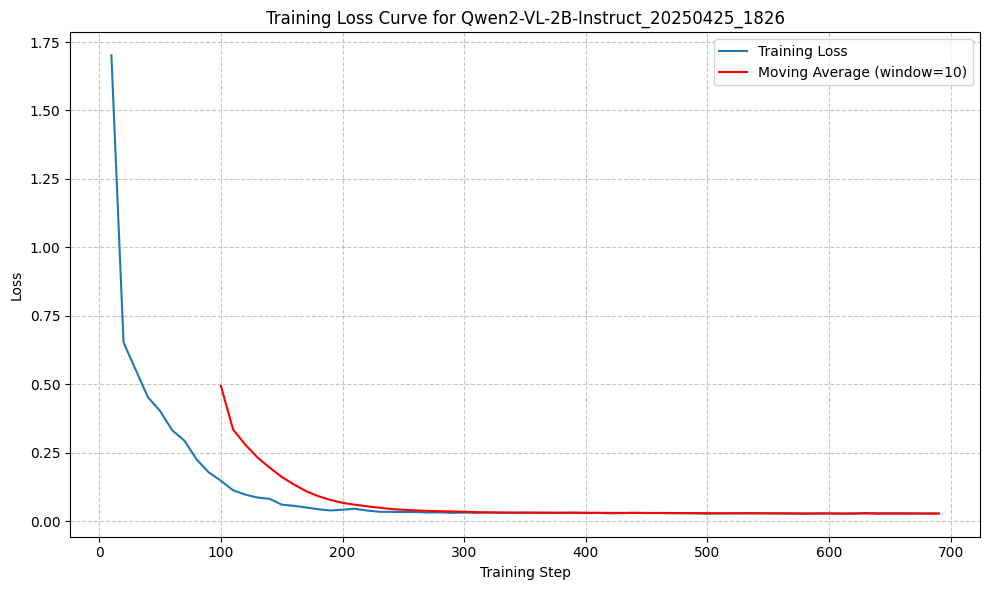

Training loss plot saved to /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/training_loss_Qwen2-VL-2B-Instruct_20250425_1826.png

Training Loss Summary:
Step	Training Loss	Moving Avg
10	1.7017	nan
40	0.4530	nan
70	0.2946	nan
100	0.1479	0.49427
130	0.0866	0.23324
160	0.0563	0.13432
190	0.0393	0.07773
220	0.0392	0.05459
250	0.0336	0.04190
280	0.0324	0.03666
310	0.0308	0.03327
340	0.0304	0.03174
370	0.0309	0.03112
400	0.0303	0.03088
430	0.0295	0.03047
460	0.0297	0.03023
490	0.0288	0.02966
520	0.0286	0.02914
550	0.0287	0.02885
580	0.0272	0.02841
610	0.0275	0.02837
640	0.0284	0.02831
670	0.0284	0.02837


,Step,Training Loss,Moving Avg
0,10,1.7017,NaN
1,20,0.6528,NaN
2,30,0.5528,NaN
3,40,0.4530,NaN
4,50,0.4027,NaN
...,...,...,...
64,650,0.0289,0.02833
65,660,0.0285,0.02833
66,670,0.0284,0.02837
67,680,0.0276,0.02841


In [36]:
plot_training_loss_from_args(args, window_size=10)

In [108]:
class MedicalImageInference:
    def __init__(self, model_path, token=None, adapter_path=None, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Initialize the inference class for medical image analysis.
        
        Parameters:
        - model_path: Path to the base model
        - token: HF token for downloading models
        - adapter_path: Path to adapter weights (used for any model type)
        - device: Computing device (cuda or cpu)
        """
        self.device = device
        print(f"Loading processor from {model_path}...")
        self.processor = AutoProcessor.from_pretrained(model_path, token=token)
               
        # Standard kwargs for all models
        base_kwargs = dict(
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else None,
            low_cpu_mem_usage=True,
            token=token
        )
        
        # Handle different model types
        if IS_LLAMA:
            # Load Llama-specific model
            print("Loading Llama model...")
            self.model = MllamaForConditionalGeneration.from_pretrained(
                model_path,
                **base_kwargs
            )
        elif IS_QWEN:
            # Load Qwen-specific model with flash attention
            print("Loading Qwen model...")
            if "Qwen2.5-VL" in model_path:
                # Add flash attention for A100 GPUs
                base_kwargs["attn_implementation"] = "flash_attention_2" if torch.cuda.is_available() else "eager"
                self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
                    model_path,
                    **base_kwargs
                )
            elif "Qwen2-VL" in model_path:
                # Add flash attention for A100 GPUs
                base_kwargs["attn_implementation"] = "flash_attention_2" if torch.cuda.is_available() else "eager"
                self.model = Qwen2VLForConditionalGeneration.from_pretrained(
                    model_path,
                    **base_kwargs
                )
        else:
            # For other models (Gemma, etc.) use AutoModelForImageTextToText
            print("Loading non-Llama, non-Qwen model...")
            non_llama_kwargs = base_kwargs.copy()
            non_llama_kwargs["attn_implementation"] = "eager"
            self.model = AutoModelForImageTextToText.from_pretrained(
                model_path,
                **non_llama_kwargs
            )
        
        # Load and apply the adapter if provided
        if adapter_path:
            print(f"Loading adapter from {adapter_path}...")
            from peft import PeftModel
            self.model = PeftModel.from_pretrained(self.model, adapter_path)
        
        self.model.eval()
        self.IS_QWEN = IS_QWEN  # Save for use in prediction
        print("Model loaded successfully")
    
    # Rest of the methods remain unchanged
    def predict(self, query_text, image_path, max_new_tokens=100):
        try:
            # Load the image
            image = Image.open(image_path).convert("RGB")

            # Create the system message
            system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            """
            
            # Format as a conversation with system and user messages
            messages = [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": query_text},
                        {"type": "image", "image": image},
                    ],
                }
            ]

            # Create model inputs
            inputs = self.processor(
                text=self.processor.apply_chat_template(messages, tokenize=False),
                images=image,
                return_tensors="pt"
            ).to(self.device)

            # Generate prediction               
            with torch.no_grad():
                generated_ids = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    temperature=0.9,
                    top_p=0.95,
                    top_k=64
                )

            # Get only the new tokens (the model's answer)
            input_length = inputs.input_ids.shape[1]
            new_tokens = generated_ids[0][input_length:]

            # After decoding the prediction, add this code to clean it:
            prediction = self.processor.decode(new_tokens, skip_special_tokens=True)

            # Clean the prediction - remove any remaining template artifacts
            prediction = prediction.strip()

            # Add this new code to remove "assistant\n\n" prefix
            
            # Add this new code to remove "assistant\n\n" prefix
            if prediction.startswith("assistant\n\n"):
                prediction = prediction[len("assistant\n\n"):]
                
            if prediction.startswith("assistant\n"):
                prediction = prediction[len("assistant\n"):]
                
            if prediction.startswith("system\n"):
                prediction = prediction[len("system\n"):]

            # Continue with existing cleaning code
            if prediction.startswith("model\n"):
                prediction = prediction[len("model\n"):]

            # Remove asterisk formatting (for Gemma model)
            prediction = re.sub(r'^\*+\s*', '', prediction)  # Remove leading asterisks and spaces
            prediction = re.sub(r'\n\*+\s*', ' ', prediction)  # Replace newline + asterisks with space
            prediction = re.sub(r'\*\s*', '', prediction)  # Remove standalone asterisks with spaces

            # Remove disclaimers and notes
            if prediction.startswith("Note:") or prediction.startswith("Disclaimer:") or prediction.startswith("*Note:"):
                if "\n" in prediction:
                    prediction = prediction.split("\n", 1)[1].strip()
                
            # Extract just the answer text
            if "Answer:" in prediction:
                parts = prediction.split("Answer:")
                if len(parts) > 1:
                    prediction = parts[1].strip()
                    
            # NEW: Remove trailing period at the end of answers
            if prediction.endswith("."):
                prediction = prediction[:-1]
                
            if prediction.startswith("<start_of_turn>model") or prediction.startswith("<start_of_turn>assistant"):
                prediction = prediction.split("\n", 1)[1] if "\n" in prediction else ""
            if prediction.endswith("<end_of_turn>"):
                prediction = prediction[:-len("<end_of_turn>")]

            return prediction.strip()
        
        except Exception as e:
            print(f"Error during prediction for {image_path}: {e}")
            traceback.print_exc()
            return "Not mentioned"  # Default to not mentioned in case of errors
    
    def batch_predict(self, processed_data_dir=None, output_file=None, max_samples=None):
        """
        Run inference on a batch of preprocessed data
        """
        # Use global constants if not provided
        if processed_data_dir is None:
            processed_data_dir = PROCESSED_VAL_DATA_DIR
            
        if output_file is None:
            output_file = os.path.join(OUTPUT_DIR, "predictions.csv")
            
        results = []
        sample_count = 0
        
        # Load all batch files
        batch_files = sorted([f for f in os.listdir(processed_data_dir) if f.startswith("val_batch_") and f.endswith(".pkl")])
        
        # Process each batch file
        for batch_file in tqdm(batch_files, desc="Processing batches"):
            with open(os.path.join(processed_data_dir, batch_file), 'rb') as f:
                batch_data = pickle.load(f)
            
            # Process each sample in the batch
            for sample in tqdm(batch_data, desc=f"Predicting {batch_file}", leave=False):
                # Get prediction
                prediction = self.predict(sample["query_text"], sample["image_path"])
                
                # Save results
                results.append({
                    "encounter_id": sample["id"],
                    "base_qid": sample["qid"],
                    "image_id": os.path.basename(sample["image_path"]),
                    "prediction": prediction
                })
                
                sample_count += 1
                if max_samples and sample_count >= max_samples:
                    break
                
            if max_samples and sample_count >= max_samples:
                break
        
        # Convert to DataFrame and save
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file, index=False)
        
        return results_df

    # Update the aggregate_predictions method in the MedicalImageInference class
    def aggregate_predictions(self, predictions_df, validation_df=None):
        """
        Aggregate predictions for each encounter and question ID
        For each encounter-question pair, collect unique predictions across all images,
        respecting the maximum allowed answers for each question type.

        Parameters:
        - predictions_df: DataFrame with prediction results
        - validation_df: Optional DataFrame containing validation data with options_en
        """
        # Define maximum allowed answers for each question type
        max_answers = {
            'CQID010': 1,  # Single answer
            'CQID011': 6,  # Up to 6 answers
            'CQID012': 6,  # Up to 6 answers
            'CQID015': 1,  # Single answer
            'CQID020': 9,  # Up to 9 answers
            'CQID025': 1,  # Single answer
            'CQID034': 1,  # Single answer
            'CQID035': 1,  # Single answer
            'CQID036': 1   # Single answer
        }

        # Set default max_answers for any question type not explicitly listed
        default_max_answers = 1

        # Group by encounter_id and base_qid
        grouped = predictions_df.groupby(['encounter_id', 'base_qid'])

        aggregated_results = []

        for (encounter_id, base_qid), group in tqdm(grouped, desc="Aggregating predictions"):
            # Extract all predictions for this group
            predictions = group['prediction'].tolist()
            image_ids = group['image_id'].tolist()

            # Process predictions to standardize format
            cleaned_predictions = []
            for pred in predictions:
                # Handle predictions that might be in a list format
                if isinstance(pred, str):
                    # Remove "(please specify)" from prediction
                    pred = pred.replace(" (please specify)", "")

                    if pred.startswith('[') and pred.endswith(']'):
                        try:
                            # Try to evaluate as a Python list
                            pred_list = safe_convert_options(pred)
                            if isinstance(pred_list, list):
                                # Clean each item in the list
                                pred_list = [p.replace(" (please specify)", "") if isinstance(p, str) else p for p in pred_list]
                                cleaned_predictions.extend(pred_list)
                                continue
                        except:
                            pass

                    # Handle comma-separated values
                    if ',' in pred:
                        # Clean each comma-separated item
                        items = [p.strip().replace(" (please specify)", "") for p in pred.split(',')]
                        cleaned_predictions.extend(items)
                    else:
                        cleaned_predictions.append(pred.strip())
                else:
                    cleaned_predictions.append(str(pred).strip())

            all_cleaned_predictions = cleaned_predictions.copy()

            # Count frequencies of each prediction
            cleaned_predictions = [p.lower() if isinstance(p, str) else str(p).lower() for p in cleaned_predictions]
            prediction_counts = Counter(cleaned_predictions)

            # Get question type for determining max allowed answers
            question_type = base_qid.split('-')[0] if '-' in base_qid else base_qid

            # Determine max allowed answers for this question type
            allowed_max = max_answers.get(question_type, default_max_answers)

            # Sort predictions by frequency (most common first)
            sorted_predictions = sorted(prediction_counts.items(), 
                                       key=lambda x: x[1], 
                                       reverse=True)

            all_sorted_predictions = sorted_predictions.copy()
            
            # Get top N predictions where N is the max allowed
            top_predictions = [p[0] for p in sorted_predictions[:allowed_max]]

            # If there are ties at the cutoff point, randomly select to meet the max limit
            if len(sorted_predictions) > allowed_max:
                # Check if there's a tie at the cutoff
                cutoff_count = sorted_predictions[allowed_max-1][1]
                tied_predictions = [p[0] for p in sorted_predictions if p[1] == cutoff_count]

                # If we have more tied predictions than slots available
                if len(tied_predictions) > 1 and len(top_predictions) > allowed_max - len(tied_predictions):
                    # Remove all tied predictions from top_predictions
                    top_predictions = [p for p in top_predictions if p not in tied_predictions]

                    # Randomly select from tied predictions to fill remaining slots
                    random.seed(42)  # For reproducibility
                    slots_remaining = allowed_max - len(top_predictions)
                    selected_tied = random.sample(tied_predictions, slots_remaining)

                    # Add the randomly selected tied predictions
                    top_predictions.extend(selected_tied)

            # If "Not mentioned" is in predictions but there are other predictions,
            # remove "Not mentioned" (unless it's the only prediction)
            if len(top_predictions) > 1 and "not mentioned" in top_predictions:
                top_predictions.remove("not mentioned")

            # Create a single, combined prediction
            combined_prediction = ", ".join(top_predictions)

            # Initialize options_en as None
            options_en = None

            # If validation_df is provided, try to get options_en from it
            if validation_df is not None:
                # Find matching rows in validation_df
                matching_rows = validation_df[(validation_df['encounter_id'] == encounter_id) & 
                                             (validation_df['base_qid'] == base_qid)]
                if not matching_rows.empty:
                    # Get options_en from the first matching row
                    options_en = matching_rows.iloc[0].get('options_en')

            result_dict = {
                "encounter_id": encounter_id,
                "base_qid": base_qid,
                "image_ids": image_ids,
                "unique_predictions": top_predictions,  # Now limited to max allowed
                "combined_prediction": combined_prediction,
                "all_raw_predictions": all_cleaned_predictions,
                "all_sorted_predictions": all_sorted_predictions
            }

            # Add options_en only if it's available
            if options_en is not None:
                result_dict["options_en"] = options_en

            aggregated_results.append(result_dict)

        # Convert to DataFrame
        aggregated_df = pd.DataFrame(aggregated_results)

        return aggregated_df

In [109]:
# Example code for running inference
def run_inference():
    # Use the global args that was already created
    # No need to create a new Args instance
    
    # Add a timestamp for unique filenames
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_type = "finetuned" if args.use_finetuning else "base"
    inference_id = f"{MODEL_NAME}_{model_type}_{timestamp}"
    
    # Create the inference object - simpler now with consistent approach
    inference = MedicalImageInference(
        model_path=args.model_path,
        token=HF_TOKEN,
        adapter_path=args.adapter_path
    )
    
    # Run inference
    predictions_file = os.path.join(OUTPUT_DIR, 
                              f"val_predictions_{inference_id}_{timestamp}{'_test' if args.test else ''}.csv")
    
    print(f"Running inference (max_samples={args.max_samples if args.max_samples else 'all'})...")
    predictions_df = inference.batch_predict(PROCESSED_VAL_DATA_DIR, predictions_file, max_samples=args.max_samples)
    return predictions_df, inference, inference_id, timestamp, predictions_file

In [110]:
# predictions_df, inference, INFERENCE_MODEL_ID, INFERENCE_TIMESTAMP, predictions_file = run_inference()

Loading processor from Qwen/Qwen2-VL-2B-Instruct...
Loading Qwen model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/finetuned-model/Qwen2-VL-2B-Instruct_20250425_1826/checkpoint-494...
Model loaded successfully
Running inference (max_samples=all)...


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting val_batch_0.pkl:   0%|          | 0/10 [00:00<?, ?it/s]

In [116]:
# Set args to use base model instead of fine-tuned model
args.use_finetuning = False

# Update args to reflect this change
args = update_args_with_checkpoint(args)

# Now run inference with the base model
predictions_df, inference, INFERENCE_MODEL_ID, INFERENCE_TIMESTAMP, predictions_file = run_inference()

Using base model WITHOUT fine-tuning.
Base model: Qwen/Qwen2-VL-2B-Instruct

Model for inference: BASE MODEL (NO FINE-TUNING)
Loading processor from Qwen/Qwen2-VL-2B-Instruct...
Loading Qwen model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully
Running inference (max_samples=all)...


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting val_batch_0.pkl:   0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
# Aggregate predictions
print("Aggregating predictions...")

# Load the validation dataset
val_dataset_path = os.path.join(OUTPUT_DIR, "val_dataset.csv")
val_dataset = pd.read_csv(val_dataset_path)

# Aggregate predictions with options_en
aggregated_df = inference.aggregate_predictions(predictions_df, validation_df=val_dataset)

# Save aggregated results
aggregated_file = os.path.join(OUTPUT_DIR, 
                             f"aggregated_predictions_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{'_test' if args.test else ''}.csv")
aggregated_df.to_csv(aggregated_file, index=False)

print(f"Inference complete. Results saved to {predictions_file} and {aggregated_file}")

Aggregating predictions...


Aggregating predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Inference complete. Results saved to /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/val_predictions_Qwen2-VL-2B-Instruct_base_20250427_204717_20250427_204717_test.csv and /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions_Qwen2-VL-2B-Instruct_base_20250427_204717_20250427_204717_test.csv


In [118]:
# Print sample of predictions for inspection
print("\nSample of raw predictions:")
predictions_df.head(3)


Sample of raw predictions:


,encounter_id,base_qid,image_id,prediction
0,ENC00852,CQID010,IMG_ENC00852_00001.jpg,system
1,ENC00852,CQID010,IMG_ENC00852_00002.jpg,system
2,ENC00852,CQID011,IMG_ENC00852_00001.jpg,system


In [119]:
print("\nSample of aggregated predictions:")
aggregated_df.head(3)


Sample of aggregated predictions:


,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
0,ENC00852,CQID010,"[IMG_ENC00852_00001.jpg, IMG_ENC00852_00002.jpg]",[system],system,"[system, system]","[(system, 2)]","['single spot', 'limited area', 'widespread', ..."
1,ENC00852,CQID011,"[IMG_ENC00852_00001.jpg, IMG_ENC00852_00002.jpg]",[system],system,"[system, system]","[(system, 2)]","['head', 'neck', 'upper extremities', 'lower e..."
2,ENC00852,CQID012,"[IMG_ENC00852_00001.jpg, IMG_ENC00852_00002.jpg]",[system],system,"[system, system]","[(system, 2)]","['size of thumb nail', 'size of palm', 'larger..."


In [120]:
# Get test suffix
TEST_SUFFIX = '_test' if args.test else ''

# Find the latest prediction file
prediction_pattern = os.path.join(OUTPUT_DIR, f"val_predictions_*{TEST_SUFFIX}.csv")
prediction_files = sorted(glob.glob(prediction_pattern), key=os.path.getmtime, reverse=True)
if not prediction_files:
    raise FileNotFoundError(f"No prediction files found matching pattern {prediction_pattern}")
LATEST_PREDICTION_FILE = prediction_files[0]
print(f"Loading latest prediction file: {LATEST_PREDICTION_FILE}")
predictions = pd.read_csv(LATEST_PREDICTION_FILE)

# Find the latest aggregated file
aggregated_pattern = os.path.join(OUTPUT_DIR, f"aggregated_predictions_*{TEST_SUFFIX}.csv")
aggregated_files = sorted(glob.glob(aggregated_pattern), key=os.path.getmtime, reverse=True)
if not aggregated_files:
    raise FileNotFoundError(f"No aggregated files found matching pattern {aggregated_pattern}")
LATEST_AGGREGATED_FILE = aggregated_files[0]
print(f"Loading latest aggregated file: {LATEST_AGGREGATED_FILE}")
aggregated = pd.read_csv(LATEST_AGGREGATED_FILE)

Loading latest prediction file: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/val_predictions_Qwen2-VL-2B-Instruct_base_20250427_204717_20250427_204717_test.csv
Loading latest aggregated file: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/aggregated_predictions_Qwen2-VL-2B-Instruct_base_20250427_204717_20250427_204717_test.csv


In [121]:
# Filter predictions that have commas (indicating multiple answers)
multi_answer_preds = predictions[predictions['prediction'].str.contains(',', na=False)]

# Display sample of multi-answer predictions
print("Sample of predictions with multiple answers:")
multi_answer_preds[["encounter_id", "base_qid", "image_id", "prediction"]].head(20)

Sample of predictions with multiple answers:


,encounter_id,base_qid,image_id,prediction


In [122]:
# Count how many multi-answer predictions we have
print(f"\nTotal multi-answer predictions: {len(multi_answer_preds)}")

# See which questions tend to have multiple answers
print("\nMulti-answer predictions by question type:")
multi_answer_preds['base_qid'].value_counts()


Total multi-answer predictions: 0

Multi-answer predictions by question type:


Series([], Name: count, dtype: int64)

In [123]:
print("\nSample of aggregated predictions:")
aggregated.head(5)


Sample of aggregated predictions:


,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en
0,ENC00852,CQID010,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['system'],system,"['system', 'system']","[('system', 2)]","['single spot', 'limited area', 'widespread', ..."
1,ENC00852,CQID011,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['system'],system,"['system', 'system']","[('system', 2)]","['head', 'neck', 'upper extremities', 'lower e..."
2,ENC00852,CQID012,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['system'],system,"['system', 'system']","[('system', 2)]","['size of thumb nail', 'size of palm', 'larger..."
3,ENC00852,CQID015,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['system'],system,"['system', 'system']","[('system', 2)]","['within hours', 'within days', 'within weeks'..."
4,ENC00852,CQID020,"['IMG_ENC00852_00001.jpg', 'IMG_ENC00852_00002...",['system'],system,"['system', 'system']","[('system', 2)]","['raised or bumpy', 'flat', 'skin loss or sunk..."


In [124]:
# Look up the aggregated result for this question
agg_result = aggregated[
    (aggregated['encounter_id'] == 'ENC00852') & 
    (aggregated['base_qid'] == 'CQID034')
]
agg_result

,encounter_id,base_qid,image_ids,unique_predictions,combined_prediction,all_raw_predictions,all_sorted_predictions,options_en


In [125]:
# Count frequency of different answers
answer_counts = predictions["prediction"].value_counts().head(10)
print("\nMost common predictions:")
print(answer_counts)


Most common predictions:
prediction
system    10
Name: count, dtype: int64


In [49]:
def format_predictions_for_official_eval_with_display(aggregated_df, output_file):
    """
    Format predictions as expected by the official evaluation script,
    mapping text answers to indices and distributing multiple answers
    across question variants when appropriate.
    Also displays the text values alongside their indices for verification.
    """
    # Define the question IDs and their allowed variants
    QIDS = [
        "CQID010-001",  # how much of body is affected (single answer)
        "CQID011-001", "CQID011-002", "CQID011-003", "CQID011-004", "CQID011-005", "CQID011-006",  # multiple answers allowed
        "CQID012-001", "CQID012-002", "CQID012-003", "CQID012-004", "CQID012-005", "CQID012-006",  # multiple answers allowed
        "CQID015-001",  # single answer
        "CQID020-001", "CQID020-002", "CQID020-003", "CQID020-004", "CQID020-005", 
        "CQID020-006", "CQID020-007", "CQID020-008", "CQID020-009",  # multiple answers allowed
        "CQID025-001",  # single answer
        "CQID034-001",  # single answer
        "CQID035-001",  # single answer
        "CQID036-001",  # single answer
    ]
    
    # Create a mapping of question base IDs to their allowed variants
    qid_variants = {}
    for qid in QIDS:
        base_qid, variant = qid.split('-')
        if base_qid not in qid_variants:
            qid_variants[base_qid] = []
        qid_variants[base_qid].append(qid)
    
    # Get all required base QIDs for a complete encounter
    required_base_qids = set(qid.split('-')[0] for qid in QIDS)
    
    formatted_predictions = []
    display_info = []
    
    # Group by encounter_id
    for encounter_id, group in aggregated_df.groupby('encounter_id'):
        # Get all base_qids for this encounter
        encounter_base_qids = set(group['base_qid'].unique())
        
        # Skip encounters that don't have all required questions
        if not required_base_qids.issubset(encounter_base_qids):
            print(f"Skipping encounter {encounter_id} - missing required questions")
            continue
        
        # Create a prediction entry for this encounter
        pred_entry = {'encounter_id': encounter_id}
        encounter_display = {'encounter_id': encounter_id, 'questions': []}
        
        # Process each question for this encounter
        for _, row in group.iterrows():
            base_qid = row['base_qid']
            
            # Skip if we don't have variants defined for this question
            if base_qid not in qid_variants:
                continue
            
            # Get the options list for this question
            options = safe_convert_options(row['options_en'])
            
            # Find the index of "Not mentioned" in the options
            not_mentioned_index = None
            for i, opt in enumerate(options):
                if opt == "Not mentioned":
                    not_mentioned_index = i
                    break
            
            # If "Not mentioned" is not in the options, default to the last option
            if not_mentioned_index is None:
                not_mentioned_index = len(options) - 1
            
            # Get predictions
            if isinstance(row['unique_predictions'], list):
                predictions = row['unique_predictions']
            else:
                try:
                    predictions = eval(row['unique_predictions'])
                except:
                    predictions = [row['unique_predictions']]
            
            # Map text predictions to indices
            prediction_indices = []
            prediction_texts = []
            
            for pred in predictions:
                pred_text = str(pred).strip()
                prediction_texts.append(pred_text)
                        
                # Find index of the prediction in options
                found = False
                for i, option in enumerate(options):
                    # Clean option text by removing "(please specify)"
                    clean_option = option.replace(" (please specify)", "").lower()

                    # Compare with cleaned option text
                    if pred_text.lower() == clean_option:
                        prediction_indices.append(i)
                        found = True
                        break
                
                # If prediction not found in options, use index 100
                if not found:
                    prediction_indices.append(100)
            
            # Remove duplicates while preserving order
            unique_indices = []
            unique_texts = []
            for idx, text in zip(prediction_indices, prediction_texts):
                if idx not in unique_indices:
                    unique_indices.append(idx)
                    unique_texts.append(text)
            
            # If 100 is in the list along with valid indices, remove 100
            if len(unique_indices) > 1 and 100 in unique_indices:
                idx_to_remove = unique_indices.index(100)
                unique_indices.remove(100)
                unique_texts.pop(idx_to_remove)
            
            # Get the available variants for this question
            available_variants = qid_variants[base_qid]
            
            # Store info for display
            question_display = {
                'base_qid': base_qid,
                'predicted_texts': unique_texts,
                'predicted_indices': unique_indices,
                'options': options,
                'not_mentioned_index': not_mentioned_index,
                'variant_assignments': {}
            }
            
            # For single-answer questions (with only one variant)
            if len(available_variants) == 1:
                if unique_indices:
                    # Store as a single integer, not a list
                    pred_entry[available_variants[0]] = unique_indices[0]
                    question_display['variant_assignments'][available_variants[0]] = {
                        'index': unique_indices[0],
                        'text': unique_texts[0] if unique_texts else "None"
                    }
                else:
                    # Default to "Not mentioned" if no prediction
                    pred_entry[available_variants[0]] = not_mentioned_index
                    question_display['variant_assignments'][available_variants[0]] = {
                        'index': not_mentioned_index,
                        'text': "Not mentioned"
                    }
            
            # For multi-answer questions
            else:
                # Distribute answers across available variants
                for i, idx in enumerate(unique_indices):
                    if i < len(available_variants):
                        # Store each answer as a single integer, not a list
                        pred_entry[available_variants[i]] = idx
                        question_display['variant_assignments'][available_variants[i]] = {
                            'index': idx,
                            'text': unique_texts[i] if i < len(unique_texts) else "None"
                        }
                
                # Fill remaining variants with a default value (usually "Not mentioned")
                for i in range(len(unique_indices), len(available_variants)):
                    # Use correct "Not mentioned" index for this question
                    pred_entry[available_variants[i]] = not_mentioned_index
                    question_display['variant_assignments'][available_variants[i]] = {
                        'index': not_mentioned_index,
                        'text': "Not mentioned"
                    }
            
            encounter_display['questions'].append(question_display)
        
        formatted_predictions.append(pred_entry)
        display_info.append(encounter_display)
    
    if not formatted_predictions:
        print("Warning: No complete encounters found in the data!")
    
    # Save to JSON file
    with open(output_file, 'w') as f:
        json.dump(formatted_predictions, f, indent=2)
    
    # Display information about the predictions
    for encounter in display_info:
        print(f"\nEncounter: {encounter['encounter_id']}")
        for question in encounter['questions']:
            print(f"  Question: {question['base_qid']}")
            print(f"  Predicted texts: {question['predicted_texts']}")
            print(f"  Predicted indices: {question['predicted_indices']}")
            print(f"  'Not mentioned' index: {question['not_mentioned_index']}")
            print("  Variant assignments:")
            for variant, assignment in question['variant_assignments'].items():
                print(f"    {variant}: index={assignment['index']} ({assignment['text']})")
            print(f"  Available options: {question['options']}")
            print()
    
    print(f"Formatted predictions saved to {output_file} ({len(formatted_predictions)} complete encounters)")
    return formatted_predictions

In [50]:
# Format and save predictions for official evaluation
predictions_json = os.path.join(OUTPUT_DIR, 
                              f"data_cvqa_sys_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.json")
format_predictions_for_official_eval_with_display(aggregated, predictions_json)
print(f"Formatted predictions saved to {predictions_json}")

Skipping encounter ENC00852 - missing required questions
Formatted predictions saved to /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys_Qwen2-VL-2B-Instruct_finetuned_20250427_200818_20250427_200818_test.json (0 complete encounters)
Formatted predictions saved to /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys_Qwen2-VL-2B-Instruct_finetuned_20250427_200818_20250427_200818_test.json


In [51]:
# Filter validation DataFrame to get the specific question and encounter
specific_question = val_dataset[(val_dataset['encounter_id'] == 'ENC00853') & 
                               (val_dataset['base_qid'] == 'CQID012')]

# Display all relevant columns
print("Question Information:")
print(f"Question text: {specific_question['question_text'].values[0]}")
print(f"Question type: {specific_question['question_type_en'].values[0]}")
print(f"Question category: {specific_question['question_category_en'].values[0]}")
print(f"Options: {specific_question['options_en'].values[0]}")
print(f"Multi-label: {specific_question['is_multi_label'].values[0]}")
print("\nClinical Context:")
print(f"Query title: {specific_question['query_title_en'].values[0]}")
print(f"Query content: {specific_question['query_content_en'].values[0]}")
print("\nImage information:")
print(f"Image ID: {specific_question['image_id'].values[0]}")
print(f"Image path: {specific_question['image_path'].values[0]}")

Question Information:
Question text: 1 How large are the affected areas? Please specify which affected area for each selection.
Question type: Size
Question category: General
Options: ['size of thumb nail', 'size of palm', 'larger area', 'Not mentioned']
Multi-label: False

Clinical Context:
Query title: Please help take a look, what kind of skin disease is this?
Query content: Suffering from the disease for more than 10 years.  It is recurrent and is vey itchy!  It happens wherever I scratch in some places.

Image information:
Image ID: IMG_ENC00853_00001.jpg
Image path: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/2025_dataset/valid/images_valid/IMG_ENC00853_00001.jpg


In [52]:
# allows us to double check the saved file
# Find the most recent data_cvqa_sys file for this model
json_pattern = os.path.join(OUTPUT_DIR, f"data_cvqa_sys_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.json")
json_files = sorted(glob.glob(json_pattern), key=os.path.getmtime, reverse=True)
if not json_files:
    raise FileNotFoundError(f"No JSON prediction files found matching pattern {json_pattern}")
    
predictions_file_path = json_files[0]
print(f"Using most recent prediction JSON: {predictions_file_path}")

with open(predictions_file_path, 'r') as f:
    formatted_preds = json.load(f)
    
# Display the first 3 entries
print("First 3 prediction entries:")
for i in range(min(3, len(formatted_preds))):
    print(f"\nPrediction {i+1}:")
    pprint(formatted_preds[i])

# Show an example of answers not in options (if any)
print("\nLooking for predictions with index 100 (not in options):")
found = False
for entry in formatted_preds:
    for key, value in entry.items():
        if key != 'encounter_id':  # Skip the encounter_id
            if (isinstance(value, list) and 100 in value) or value == 100:
                print(f"\nFound prediction not in options:")
                print(f"Encounter: {entry['encounter_id']}")
                print(f"Question: {key}")
                print(f"Prediction indices: {value}")
                
                # Load original predictions for this encounter
                # Use the correct aggregated file with the model ID and timestamp
                aggregated_file_path = os.path.join(OUTPUT_DIR, 
                                                  f"aggregated_predictions_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.csv")
                
                # Check if the file exists before trying to open it
                if not os.path.exists(aggregated_file_path):
                    print(f"Warning: Could not find aggregated predictions file at {aggregated_file_path}")
                    # Try to find it using glob
                    agg_pattern = os.path.join(OUTPUT_DIR, f"aggregated_predictions_*{TEST_SUFFIX}.csv")
                    agg_files = sorted(glob.glob(agg_pattern), key=os.path.getmtime, reverse=True)
                    if agg_files:
                        aggregated_file_path = agg_files[0]
                        print(f"Using most recent aggregated file instead: {aggregated_file_path}")
                    else:
                        print("No aggregated prediction files found. Skipping detailed analysis.")
                        continue
                
                agg_df = pd.read_csv(aggregated_file_path)
                base_qid = key.split('-')[0]
                encounter = entry['encounter_id']
                match = agg_df[(agg_df['encounter_id'] == encounter) & (agg_df['base_qid'] == base_qid)]
                if not match.empty:
                    print(f"Original prediction text: {match['combined_prediction'].values[0]}")
                    print(f"Available options: {match['options_en'].values[0]}")
                found = True
                break
    if found:
        break

if not found:
    print("No predictions with index 100 found in the first few entries.")

# Show statistics
question_counts = {}
for entry in formatted_preds:
    qid_count = len(entry) - 1  # Subtract 1 for encounter_id
    if qid_count in question_counts:
        question_counts[qid_count] += 1
    else:
        question_counts[qid_count] = 1

print("\nNumber of questions per encounter:")
for count, num_entries in sorted(question_counts.items()):
    print(f"{count} questions: {num_entries} encounters")

Using most recent prediction JSON: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys_Qwen2-VL-2B-Instruct_finetuned_20250427_200818_20250427_200818_test.json
First 3 prediction entries:

Looking for predictions with index 100 (not in options):
No predictions with index 100 found in the first few entries.

Number of questions per encounter:


In [53]:
# Use INFERENCE_MODEL_ID for consistency
SUBMISSION_TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Find the most recent data_cvqa_sys file for this model
json_pattern = os.path.join(OUTPUT_DIR, f"data_cvqa_sys_{INFERENCE_MODEL_ID}*{TEST_SUFFIX}.json")
json_files = sorted(glob.glob(json_pattern), key=os.path.getmtime, reverse=True)
if not json_files:
    raise FileNotFoundError(f"No JSON prediction files found matching pattern {json_pattern}")
most_recent_json = json_files[0]
print(f"Using most recent prediction JSON: {most_recent_json}")

# Create directory for empty masks_preds if it doesn't exist
masks_preds_dir = os.path.join(OUTPUT_DIR, "masks_preds")
os.makedirs(masks_preds_dir, exist_ok=True)

# Create submission folder with timestamp
submission_dir = os.path.join(OUTPUT_DIR, f"submission_{INFERENCE_MODEL_ID}_{SUBMISSION_TIMESTAMP}")
os.makedirs(submission_dir, exist_ok=True)

# Copy the most recent JSON with the exact required filename
dest_json = os.path.join(submission_dir, "data_cvqa_sys.json")
shutil.copy2(most_recent_json, dest_json)

# Create empty masks_preds directory in the submission folder
submission_masks_dir = os.path.join(submission_dir, "masks_preds")
os.makedirs(submission_masks_dir, exist_ok=True)

# Create the zip file with both components
zip_path = os.path.join(OUTPUT_DIR, f"mysubmission_{INFERENCE_MODEL_ID}_{SUBMISSION_TIMESTAMP}.zip")
with zipfile.ZipFile(zip_path, 'w') as zipf:
    # Add the json file
    zipf.write(dest_json, arcname="data_cvqa_sys.json")
    
    # Add the masks_preds directory (it will be empty)
    zipf.write(submission_masks_dir, arcname="masks_preds")

print(f"Submission package created at: {zip_path}")
print(f"Files included:")
print(f" - data_cvqa_sys.json (copied from {most_recent_json})")
print(f" - masks_preds/ (empty directory)")

Using most recent prediction JSON: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys_Qwen2-VL-2B-Instruct_finetuned_20250427_200818_20250427_200818_test.json
Submission package created at: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/mysubmission_Qwen2-VL-2B-Instruct_finetuned_20250427_200818_20250427_201113.zip
Files included:
 - data_cvqa_sys.json (copied from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/data_cvqa_sys_Qwen2-VL-2B-Instruct_finetuned_20250427_200818_20250427_200818_test.json)
 - masks_preds/ (empty directory)


Measuring input context window

In [54]:
def analyze_dataset_tokens(dataset_dir=None, processor=None, num_samples=None):
    """
    Analyze token counts in the dataset without running training or inference
    
    Args:
        dataset_dir: Path to the processed dataset directory
        processor: The processor from the model
        num_samples: Optional limit on number of samples to process
    """
    # Check if processor is provided
    if processor is None:
        raise ValueError("Processor must be provided for tokenization")
    
    # Check if directory exists
    if not os.path.exists(dataset_dir):
        print(f"Directory not found: {dataset_dir}")
        return None
    
    token_stats = {
        "samples": [],
        "summary": {}
    }
    
    # Find batch files
    batch_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("batch_") and f.endswith(".pkl") or
                          f.startswith("val_batch_") and f.endswith(".pkl")])
    
    if not batch_files:
        print(f"No batch files found in {dataset_dir}")
        return None
    
    total_tokens = 0
    max_tokens = 0
    min_tokens = float('inf')
    sample_count = 0
    all_token_counts = []
    
    for batch_file in tqdm(batch_files, desc="Analyzing batches"):
        try:
            with open(os.path.join(dataset_dir, batch_file), 'rb') as f:
                batch_data = pickle.load(f)
            
            for sample in tqdm(batch_data, desc=f"Analyzing {batch_file}", leave=False):
                if not isinstance(sample, dict) or "query_text" not in sample:
                    print(f"Warning: Unexpected sample format in {batch_file}")
                    continue
                    
                # Create the input as it would be during inference                
                
                system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

                IMPORTANT: 
                - Respond ONLY with the exact text of the option(s) that apply
                - Do not provide any explanations
                - Do not include the numbers that appear before options (like '1.' or '2')
                - Do not write "Options:" or similar prefixes
                - Do not write "Answer:" or similar prefixes
                - Multiple answers should be separated by commas
                - If unsure, respond with "Not mentioned"
                - The 'Background Clinical Information' section contains context to help you answer the main question
                - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
                """
                
                # Format messages similar to during inference
                messages = [
                    {
                        "role": "system",
                        "content": [{"type": "text", "text": system_message}],
                    },
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": sample["query_text"]},
                            # Don't need to actually load the image for token counting
                            {"type": "image", "image": "IMAGE_PLACEHOLDER"},
                        ],
                    },
                ]
                
                # Get formatted text for tokenization
                text = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)
                
                # Count tokens
                tokens = processor.tokenizer.encode(text)
                token_count = len(tokens)
                all_token_counts.append(token_count)
                
                # Update statistics
                total_tokens += token_count
                max_tokens = max(max_tokens, token_count)
                min_tokens = min(min_tokens, token_count)
                
                # Store sample info
                token_stats["samples"].append({
                    "id": sample.get("id", "unknown"),
                    "qid": sample.get("qid", "unknown"),
                    "image": os.path.basename(sample.get("image_path", "unknown")),
                    "token_count": token_count,
                    "text_length": len(sample["query_text"])
                })
                
                sample_count += 1
                if num_samples and sample_count >= num_samples:
                    break
            
            if num_samples and sample_count >= num_samples:
                break
                
        except Exception as e:
            print(f"Error processing batch {batch_file}: {e}")
            continue
    
    if sample_count == 0:
        print("No samples were successfully processed")
        return None
    
    # Calculate summary statistics
    token_stats["summary"] = {
        "total_samples": sample_count,
        "total_tokens": total_tokens,
        "avg_tokens_per_sample": total_tokens / sample_count,
        "max_tokens": max_tokens,
        "min_tokens": min_tokens,
        "median_tokens": np.median(all_token_counts),
        "percentile_90": np.percentile(all_token_counts, 90),
        "percentile_99": np.percentile(all_token_counts, 99)
    }
    
    # Save the analysis
    output_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(dataset_dir)}_token_analysis.json")
    with open(output_path, "w") as f:
        json.dump(token_stats, f, indent=2)
    
    # Display summary
    print("\nToken Usage Analysis:")
    print(f"Total samples analyzed: {sample_count}")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Average tokens per sample: {total_tokens/sample_count:.2f}")
    print(f"Median tokens per sample: {np.median(all_token_counts):.2f}")
    print(f"90th percentile: {np.percentile(all_token_counts, 90):.2f}")
    print(f"99th percentile: {np.percentile(all_token_counts, 99):.2f}")
    print(f"Max tokens in a sample: {max_tokens}")
    print(f"Min tokens in a sample: {min_tokens}")
    print(f"Percentage of 128K context window used (max): {(max_tokens/128000)*100:.2f}%")
    
    # Create better histogram
    plt.figure(figsize=(12, 8))
    
    # Use bins based on data range
    bin_count = min(50, len(set(all_token_counts)))
    
    # Plot histogram with actual counts
    n, bins, patches = plt.hist(all_token_counts, bins=bin_count, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add mean line
    plt.axvline(x=np.mean(all_token_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_token_counts):.1f}')
    
    # Add median line
    plt.axvline(x=np.median(all_token_counts), color='green', linestyle='-', linewidth=2, label=f'Median: {np.median(all_token_counts):.1f}')
    
    # Add 90th percentile line
    plt.axvline(x=np.percentile(all_token_counts, 90), color='orange', linestyle='-.', linewidth=2, label=f'90th percentile: {np.percentile(all_token_counts, 90):.1f}')
    
    plt.title(f"Distribution of Token Counts (n={sample_count})", fontsize=16)
    plt.xlabel("Token Count", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text with stats
    stats_text = (
        f"Min: {min_tokens}\n"
        f"Max: {max_tokens}\n"
        f"Mean: {np.mean(all_token_counts):.1f}\n"
        f"Median: {np.median(all_token_counts):.1f}\n"
        f"Std Dev: {np.std(all_token_counts):.1f}\n"
        f"90th %ile: {np.percentile(all_token_counts, 90):.1f}\n"
        f"% of 128K used: {(max_tokens/128000)*100:.2f}%"
    )
    
    # Position text in the upper right
    plt.text(0.95, 0.95, stats_text, 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save the figure
    plt_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(dataset_dir)}_token_distribution.png")
    plt.savefig(plt_path, dpi=300)
    plt.show()
    
    return token_stats

# Now run for both datasets using global constants
try:
    print("Analyzing training data tokens...")
    train_token_stats = analyze_dataset_tokens(PROCESSED_DATA_DIR, processor)
    
    print("\nAnalyzing validation data tokens...")
    val_token_stats = analyze_dataset_tokens(PROCESSED_VAL_DATA_DIR, processor)
    
    print("\nToken analysis complete! Files saved to the outputs directory.")
except Exception as e:
    print(f"Error running token analysis: {e}")
    traceback.print_exc()

Analyzing training data tokens...
Error running token analysis: name 'PROCESSED_DATA_DIR' is not defined


Traceback (most recent call last):
  File "/tmp/ipykernel_3122518/1261739612.py", line 200, in <module>
    train_token_stats = analyze_dataset_tokens(PROCESSED_DATA_DIR, processor)
NameError: name 'PROCESSED_DATA_DIR' is not defined. Did you mean: 'PROCESSED_VAL_DATA_DIR'?


In [55]:
def check_for_other_please_specify(df, column_name='valid_answers'):
    """
    Check if "other (please specify)" appears as a ground truth answer
    
    Args:
        df: DataFrame to check (train or validation)
        column_name: Column containing the answers (default: 'valid_answers')
    
    Returns:
        Dictionary with statistics about occurrences
    """
    # Convert string representations to lists if needed
    if df[column_name].dtype == 'object':
        
        def safe_eval(x):
            try:
                if isinstance(x, list):
                    return x
                if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
                    return ast.literal_eval(x)
                return [x]  # Return single item as list
            except:
                return [str(x)]  # Return as single-item list if eval fails
        
        # Apply the conversion
        valid_answers_lists = df[column_name].apply(safe_eval)
    else:
        valid_answers_lists = df[column_name]
    
    # Check for matches
    matches = []
    for idx, answers in enumerate(valid_answers_lists):
        for answer in answers:
            if isinstance(answer, str) and "other (please specify)" in answer.lower():
                matches.append({
                    "index": idx,
                    "encounter_id": df.iloc[idx].get('encounter_id', 'unknown'),
                    "base_qid": df.iloc[idx].get('base_qid', 'unknown'),
                    "answer": answer,
                    "all_answers": answers
                })
    
    # Summarize findings
    results = {
        "total_rows": len(df),
        "match_count": len(matches),
        "percentage": (len(matches) / len(df)) * 100 if len(df) > 0 else 0,
        "matches": matches
    }
    
    # Print summary
    print(f"Results for {column_name} in dataset with {len(df)} rows:")
    print(f"Found {len(matches)} occurrences of 'other (please specify)' ({results['percentage']:.2f}%)")
    
    if matches:
        print("\nSample matches:")
        for i, match in enumerate(matches[:5]):  # Show up to 5 examples
            print(f"{i+1}. Index {match['index']}, Encounter: {match['encounter_id']}, QID: {match['base_qid']}")
            print(f"   Answer: {match['answer']}")
            print(f"   All answers: {match['all_answers']}")
    
    return results
def check_for_other_please_specify(df, column_name='valid_answers'):
    """
    Check if "other (please specify)" appears as a ground truth answer
    
    Args:
        df: DataFrame to check (train or validation)
        column_name: Column containing the answers (default: 'valid_answers')
    
    Returns:
        Dictionary with statistics about occurrences
    """
    # Convert string representations to lists if needed
    if df[column_name].dtype == 'object':
        
        def safe_eval(x):
            try:
                if isinstance(x, list):
                    return x
                if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
                    return ast.literal_eval(x)
                return [x]  # Return single item as list
            except:
                return [str(x)]  # Return as single-item list if eval fails
        
        # Apply the conversion
        valid_answers_lists = df[column_name].apply(safe_eval)
    else:
        valid_answers_lists = df[column_name]
    
    # Check for matches
    matches = []
    for idx, answers in enumerate(valid_answers_lists):
        for answer in answers:
            if isinstance(answer, str) and "other (please specify)" in answer.lower():
                matches.append({
                    "index": idx,
                    "encounter_id": df.iloc[idx].get('encounter_id', 'unknown'),
                    "base_qid": df.iloc[idx].get('base_qid', 'unknown'),
                    "answer": answer,
                    "all_answers": answers
                })
    
    # Summarize findings
    results = {
        "total_rows": len(df),
        "match_count": len(matches),
        "percentage": (len(matches) / len(df)) * 100 if len(df) > 0 else 0,
        "matches": matches
    }
    
    # Print summary
    print(f"Results for {column_name} in dataset with {len(df)} rows:")
    print(f"Found {len(matches)} occurrences of 'other (please specify)' ({results['percentage']:.2f}%)")
    
    if matches:
        print("\nSample matches:")
        for i, match in enumerate(matches[:5]):  # Show up to 5 examples
            print(f"{i+1}. Index {match['index']}, Encounter: {match['encounter_id']}, QID: {match['base_qid']}")
            print(f"   Answer: {match['answer']}")
            print(f"   All answers: {match['all_answers']}")
    
    return results

# Check training data
print("CHECKING TRAINING DATA:")
train_results = check_for_other_please_specify(train_df)

# Check validation data
print("\nCHECKING VALIDATION DATA:")
val_results = check_for_other_please_specify(val_df)

# Check specifically for CQID011 (where "other (please specify)" is likely)
print("\nCHECKING CQID011 IN TRAINING DATA:")
train_cqid011 = train_df[train_df['base_qid'] == 'CQID011']
train_cqid011_results = check_for_other_please_specify(train_cqid011)

print("\nCHECKING CQID011 IN VALIDATION DATA:")
val_cqid011 = val_df[val_df['base_qid'] == 'CQID011']
val_cqid011_results = check_for_other_please_specify(val_cqid011)

CHECKING TRAINING DATA:
Results for valid_answers in dataset with 10 rows:
Found 0 occurrences of 'other (please specify)' (0.00%)

CHECKING VALIDATION DATA:
Results for valid_answers in dataset with 10 rows:
Found 0 occurrences of 'other (please specify)' (0.00%)

CHECKING CQID011 IN TRAINING DATA:
Results for valid_answers in dataset with 2 rows:
Found 0 occurrences of 'other (please specify)' (0.00%)

CHECKING CQID011 IN VALIDATION DATA:
Results for valid_answers in dataset with 2 rows:
Found 0 occurrences of 'other (please specify)' (0.00%)


In [56]:
print("\nCHECKING CQID013 IN VALIDATION DATA:")
val_cqid013 = val_df[val_df['base_qid'] == 'CQID013']
val_cqid013_results = check_for_other_please_specify(val_cqid013)


CHECKING CQID013 IN VALIDATION DATA:
Results for valid_answers in dataset with 0 rows:
Found 0 occurrences of 'other (please specify)' (0.00%)
